# PRÁCTICA DEEP LEARNING
### C. JAVIER ÁVILA BERMEJO
En esta práctica se muestra el proceso para cargar, tratar y el modelado un dataset de airbnb con el objetivo de predecir el precio de un piso en madrid a partir de una serie de variables númericas, categóricas e imagenes del dataset.
Se aplicara algoritmo de redes neuronales para ambos procesamientos.

In [10]:
#Librerías utilizadas
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import statistics as stat
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn import preprocessing
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
import imageio as io
import cv2
from numpy import moveaxis
import PIL.Image
import concurrent
from tqdm import tqdm

In [11]:
#Carga de los datos a utilizar en la práctica
#Plantamos una semilla para reproducir los resultados obtenidos
np.random.seed(42)
full_data = pd.read_csv('./airbnb-listings.csv', sep =';', decimal='.')
#Limitamos la muestra del dataset para no superar la capacidad kernel
full_data = full_data.sample(8000, random_state=42)
#Dividimos train y test
data, test = train_test_split(full_data, test_size=0.3, shuffle=True, random_state=42)
#Guardamos en dos ficheros separados
data.to_csv('./data.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

In [12]:
#Cargamos los datos de train
data = pd.read_csv('./data.csv', sep=';', decimal='.')

In [13]:
# Se crea una lista con el índice y la url de las imagenes
images_paths = []
for i, img_url in enumerate(data['Thumbnail Url']):
  images_paths.append([i, img_url])

In [14]:
# Se define la función para descargar las imagen y recibir el index con lo que lo guardamos

def get_image(data_url, target_size=(224, 224)):
    idx, url = data_url
    try:
        img = io.imread(url)

        # Some images may be in black & white. I convert to to RGB as otherwise it generates error
        if img.ndim < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
        # If channels info is in first place, move to last position
        if (img.shape[0] < img.shape[1] ) and (img.shape[0] < img.shape[2]):
          img = moveaxis(img, 0, 2)

        # In case any image is RGBA, take onloy RGB channels
        img = img[...,:3]
        
        img = cv2.resize(img, dsize=target_size)
        return img, idx
        
    except IOError as err:
        return (None, idx)

In [15]:
# Creamos el tensor para guardar las imagenes
loaded_images = np.zeros((len(images_paths), 224, 224, 3), dtype=np.uint8)

# También creamos el tensor con las imagenes cargadas y las que no
was_loaded = np.zeros(len(images_paths))

In [16]:
# Creating pool to load images. By default, it uses as much cores as your machine has

with concurrent.futures.ProcessPoolExecutor() as executor:


    for (img, idx) in tqdm(executor.map(get_image, images_paths), total=len(images_paths)):

        # Loading the images

        if img is not None:
            loaded_images[idx] = img
            was_loaded[idx] = 1
        else:
            was_loaded[idx] = 0

print('Finished!')
print(f'Number of images loaded: {sum(was_loaded)}/{len(images_paths)}')

100%|███████████████████████████████████████| 5600/5600 [01:05<00:00, 84.92it/s]


Finished!
Number of images loaded: 4559.0/5600


In [17]:
# Guardamos ambos tensores
np.save('images.npy', loaded_images)
np.save('was_loaded.npy', was_loaded)

## Preprocesamiento
Vamos a revisar la información proporcionada por el dataset.

In [18]:
data

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,7762473,https://www.airbnb.com/rooms/7762473,20170407214119,2017-04-08,Que apartamento tan bonito!!!!,"Supercentrico. En la Gran Via, entre Plaza Esp...",La ubicacion tan extraordinaria. Y los medios ...,"Supercentrico. En la Gran Via, entre Plaza Esp...",none,Estando en el corazon de Madrid en la casa te ...,...,10.0,10.0,8.0,NaN,NaN,strict,1,1.46,"40.4218181637859,-3.708066496224637","Host Has Profile Pic,Requires License"
1,10563232,https://www.airbnb.com/rooms/10563232,20170407214119,2017-04-08,Big Double room in front of Retiro,120m2 flat in front of the Retiro Park and 10 ...,"Your room is comfortable, quiet and silent, r...",120m2 flat in front of the Retiro Park and 10 ...,none,If you are looking for an authentic place to s...,...,10.0,10.0,10.0,NaN,NaN,flexible,1,2.45,"40.41769483156992,-3.6775896400496695","Host Is Superhost,Host Has Profile Pic,Require..."
2,1038453,https://www.airbnb.com/rooms/1038453,20170407214119,2017-04-08,APARTMENTS CUATRO TORRES CTB,APARTMENT IN A MODERN BUILDING IN THE NORTH AR...,Apartment (maximum capacity: 4 people). This a...,APARTMENT IN A MODERN BUILDING IN THE NORTH AR...,none,Situación y comunicaciones: Es una zona modern...,...,9.0,8.0,9.0,NaN,NaN,moderate,26,0.18,"40.471663946453724,-3.6930674194560864","Host Has Profile Pic,Host Identity Verified,Is..."
3,11376922,https://www.airbnb.com/rooms/11376922,20170407214119,2017-04-08,Private Room in city center + wifi,Private room in city center. En el barrio de ...,"habitación privada muy luminosa, con ventana a...",Private room in city center. En el barrio de ...,none,Lavapiés es uno de los barrios más populares d...,...,10.0,10.0,10.0,NaN,NaN,moderate,1,3.04,"40.4098552104979,-3.7032886224680057","Host Is Superhost,Host Has Profile Pic,Host Id..."
4,4208724,https://www.airbnb.com/rooms/4208724,20170407214119,2017-04-08,Apartment with parking,"Very luminous, spacious and quiet 110 m2 refur...",Located on the 5th floor of a modern building ...,"Very luminous, spacious and quiet 110 m2 refur...",none,The house has views over the neighbourhood’s g...,...,10.0,10.0,10.0,NaN,NaN,flexible,1,1.12,"40.43736393345886,-3.702289573379177","Host Is Superhost,Host Has Profile Pic,Is Loca..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,11406591,https://www.airbnb.com/rooms/11406591,20170407214119,2017-04-08,Habitación Madrid CENTRO y DESAYUNO,Una habitación en un piso muy acogedor y con ...,NaN,Una habitación en un piso muy acogedor y con ...,none,El barrio de Arganzuela es un barrio que últim...,...,10.0,9.0,10.0,NaN,NaN,flexible,1,5.73,"40.39913078752906,-3.7021701118001076","Host Is Superhost,Host Has Profile Pic,Require..."
5596,13934525,https://www.airbnb.com/rooms/13934525,20170407214119,2017-04-08,Great apartment near to Parque del Retiro,Beautiful luxurious apartment in prime locatio...,"Close to Retiro Park, Puerta de Alcalá and mai...",Beautiful luxurious apartment in prime locatio...,none,NaN,...,10.0,10.0,10.0,NaN,NaN,flexible,1,0.12,"40.42265167543889,-3.685306699394012","Host Has Profile Pic,Host Identity Verified,Is..."
5597,13529348,https://www.airbnb.com/rooms/13529348,20170407214119,2017-04-08,Vintage apartment renovated in the museums area.,Our apartment is just next to CaixaForum Museu...,The apartment is just in front of Reina Sofía ...,Our apartment is just next to CaixaForum Museu...,none,The apartment is in the border of Las Letras a...,...,9.0,9.0,9.0,NaN,NaN,moderate,2,1.58,"40.40960432454764,-3.6942290428192517","Host Is Superhost,Host Has Profile Pic,Host Id..."
5598,14944725,https://www.airbnb.com/rooms/14944725,20170407214119,2017-04-08,"2 ""Room with a view ""","Lugares 

In [19]:
data.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

Después de revisar el csv se eliminan las columnas que no van a formar parte del modelo por contener mucha información textual (complicando el análisis) o por no tener información de interés para el modelo(ejemplo, urls e identificadores). 
También se eliminan las columnas que se estén estrechamente relacionadas con otras de forma obvia (ejemplo, la columna geolocalización = las columnas de latitud y logitud).
Por último, también se eliminan las columnas que no tengan información de valor por falta de variabilidad o que repliquen la información de otras columnas.

In [20]:
data.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Thumbnail Url',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Street',
       'Neighbourhood', 'State', 'Market',
       'Smart Location', 'Country Code', 
       'Calendar Updated',
       'Has Availability', 'Availability 30', 'Availability 60',
       'Availability 90', 'Calendar last Scraped',
       'First Review', 'Last Review',
       'License', 'Jurisdiction Names',
       'Calculated host listings count',
       'Geolocation'], axis = 1, inplace = True)

In [21]:
data.head()

,Host Response Time,Host Response Rate,Host Verifications,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,Zipcode,Country,Latitude,Longitude,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Reviews per Month,Features
0,within a few hours,100.0,"email,phone,reviews",Universidad,Centro,Madrid,28013,Spain,40.421818,-3.708066,...,80.0,9.0,7.0,9.0,10.0,10.0,8.0,strict,1.46,"Host Has Profile Pic,Requires License"
1,NaN,NaN,"email,phone,reviews",Ibiza,Retiro,Madrid,NaN,Spain,40.417695,-3.677590,...,98.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,2.45,"Host Is Superhost,Host Has Profile Pic,Require..."
2,within a day,100.0,"email,phone,facebook,reviews,jumio",Almenara,Tetuán,Madrid,28029,Spain,40.471664,-3.693067,...,83.0,8.0,9.0,9.0,9.0,8.0,9.0,moderate,0.18,"Host Has Profile Pic,Host Identity Verified,Is..."
3,within an hour,100.0,"email,phone,facebook,reviews,jumio",Embajadores,Centro,Madrid,NaN,Spain,40.409855,-3.703289,...,97.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,3.04,"Host Is Superhost,Host Has Profile Pic,Host Id..."
4,within an hour,100.0,"email,phone,facebook,reviews",Trafalgar,Chamberí,Madrid,28010,Spain,40.437364,-3.702290,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,flexible,1.12,"Host Is Superhost,Host Has Profile Pic,Is Loca..."


Ahora filtramos las columnas de country y city, igual a Spain y Madrid. Posteriormente las eliminamos del modelo

In [22]:
data= data[data['Country']=='Spain']
data= data[data['City']=='Madrid']
print(data['Country'].unique())
print(data['City'].unique())
data.drop(['Country', 'City'], axis = 1, inplace = True)
print(data.shape)
data.head().T

['Spain']
['Madrid']
(5290, 38)


,0,1,2,3,4
Host Response Time,within a few hours,NaN,within a day,within an hour,within an hour
Host Response Rate,100.0,NaN,100.0,100.0,100.0
Host Verifications,"email,phone,reviews","email,phone,reviews","email,phone,facebook,reviews,jumio","email,phone,facebook,reviews,jumio","email,phone,facebook,reviews"
Neighbourhood Cleansed,Universidad,Ibiza,Almenara,Embajadores,Trafalgar
Neighbourhood Group Cleansed,Centro,Retiro,Tetuán,Centro,Chamberí
Zipcode,28013,NaN,28029,NaN,28010
Latitude,40.421818,40.417695,40.471664,40.409855,40.437364
Longitude,-3.708066,-3.67759,-3.693067,-3.703289,-3.70229
Property Type,Apartment,Apartment,Apartment,House,Apartment
Room Type,Entire home/apt,Private room,Entire home/apt,Private room,Entire home/apt


Ahora revisaremos los valores NA's de cada columna.

In [23]:
for column in range(0, data.shape[1]):
    tasa_na = round((data[data.columns.values[column]].isnull().sum()/data.shape[0])*100, 2)
    if tasa_na > 0:
        print(f'La tasa de NAs es de {data.columns.values[column]} es: {tasa_na}%')

La tasa de NAs es de Host Response Time es: 13.04%
La tasa de NAs es de Host Response Rate es: 13.04%
La tasa de NAs es de Host Verifications es: 0.08%
La tasa de NAs es de Zipcode es: 3.65%
La tasa de NAs es de Bathrooms es: 0.47%
La tasa de NAs es de Bedrooms es: 0.21%
La tasa de NAs es de Beds es: 0.38%
La tasa de NAs es de Amenities es: 0.79%
La tasa de NAs es de Square Feet es: 96.33%
La tasa de NAs es de Price es: 0.06%
La tasa de NAs es de Weekly Price es: 74.9%
La tasa de NAs es de Monthly Price es: 74.84%
La tasa de NAs es de Security Deposit es: 57.88%
La tasa de NAs es de Cleaning Fee es: 41.55%
La tasa de NAs es de Review Scores Rating es: 21.51%
La tasa de NAs es de Review Scores Accuracy es: 21.63%
La tasa de NAs es de Review Scores Cleanliness es: 21.57%
La tasa de NAs es de Review Scores Checkin es: 21.64%
La tasa de NAs es de Review Scores Communication es: 21.55%
La tasa de NAs es de Review Scores Location es: 21.68%
La tasa de NAs es de Review Scores Value es: 21.68%

Vamos a eliminar las columnas Square Feet, Weekly Price y Monthly Price por la gran cantidad de NA's.

In [24]:
data.drop(['Weekly Price', 'Monthly Price', 'Square Feet'],axis=1, inplace=True)

También eliminaremos las filas con Price = NA. Siendo necesaria para entrenar y validar el modelo.

In [25]:
data = data[data.Price.notnull()]

In [26]:
for column in range(0, data.shape[1]):
    tasa_na = round((data[data.columns.values[column]].isnull().sum()/data.shape[0])*100, 2)
    if tasa_na > 0:
        print(f'La tasa de NAs es de {data.columns.values[column]} es: {tasa_na}%')

La tasa de NAs es de Host Response Time es: 13.03%
La tasa de NAs es de Host Response Rate es: 13.03%
La tasa de NAs es de Host Verifications es: 0.06%
La tasa de NAs es de Zipcode es: 3.65%
La tasa de NAs es de Bathrooms es: 0.45%
La tasa de NAs es de Bedrooms es: 0.21%
La tasa de NAs es de Beds es: 0.36%
La tasa de NAs es de Amenities es: 0.78%
La tasa de NAs es de Security Deposit es: 57.86%
La tasa de NAs es de Cleaning Fee es: 41.54%
La tasa de NAs es de Review Scores Rating es: 21.47%
La tasa de NAs es de Review Scores Accuracy es: 21.58%
La tasa de NAs es de Review Scores Cleanliness es: 21.52%
La tasa de NAs es de Review Scores Checkin es: 21.6%
La tasa de NAs es de Review Scores Communication es: 21.51%
La tasa de NAs es de Review Scores Location es: 21.64%
La tasa de NAs es de Review Scores Value es: 21.64%
La tasa de NAs es de Reviews per Month es: 20.6%


Investigamos los NA y la naturaleza de la columna en detalle.

In [27]:
data['Host Response Time'].unique() #Realizaremos una codificacion de One Shot

array(['within a few hours', nan, 'within a day', 'within an hour',
       'a few days or more'], dtype=object)

In [28]:
data['Host Response Rate'].unique() #Imputaremos con una media

array([100.,  nan,  40.,  99.,  20.,  70.,  50.,  86.,  91.,  90.,  89.,
        69.,  67.,  68.,  95.,  94.,  88.,  75.,  47.,  96.,  97.,  98.,
        79.,  76.,  80.,  81.,  92.,  93.,  65.,  55.,  87.,  78.,   0.,
        43.,  33.,  24.,  60.,  57.,  85.,  29.,   9.,  73.,  56.,  42.,
        71.,  82.,  83.,  25.,  13.,  61.,  64.,  46.,  30.,  77.,  72.,
        63.,  35.,  62.,  84.,  11.,  38.,  26.])

In [29]:
data['Host Verifications'].unique()#Realizaremos una codificación por número de verificaciones

array(['email,phone,reviews', 'email,phone,facebook,reviews,jumio',
       'email,phone,facebook,reviews',
       'email,phone,facebook,reviews,jumio,government_id',
       'email,phone,reviews,jumio,government_id', 'email,phone,facebook',
       'email,phone', 'email,phone,google,reviews', 'phone,reviews',
       'email,phone,facebook,reviews,jumio,offline_government_id,government_id',
       'email,phone,reviews,jumio,government_id,work_email',
       'email,phone,reviews,jumio',
       'email,phone,reviews,manual_offline,jumio', 'email,phone,jumio',
       'email,phone,reviews,jumio,work_email',
       'email,phone,reviews,jumio,offline_government_id,government_id',
       'email,phone,reviews,work_email', 'email,reviews',
       'email,phone,facebook,reviews,work_email',
       'email,phone,google,linkedin,reviews,jumio,government_id',
       'email,phone,facebook,google,reviews,jumio,government_id', 'phone',
       'email,phone,linkedin,reviews,jumio,offline_government_id,governme

In [30]:
data['Bathrooms'].unique()#Realizaremos imputación de los NA con la moda

array([1. , 2. , 0. , 0.5, 1.5, 3. , nan, 2.5, 6. , 8. , 5. , 4.5, 4. ,
       5.5, 3.5])

In [31]:
data['Bedrooms'].unique()#Realizaremos imputación de los NA con la moda

array([ 1.,  2.,  0.,  3.,  4.,  5.,  7., nan,  6., 10.,  8.])

In [32]:
data['Beds'].unique()#Realizaremos imputación de los NA con la moda

array([ 2.,  1.,  3.,  5.,  9.,  4.,  7.,  8.,  6., 16., nan, 10., 14.,
       12., 13., 11.])

In [33]:
data['Amenities'].unique()#Realizaremos codificación mediante el sumatorio de las media suavizada por la cantidad de amenities

array(['TV,Internet,Wireless Internet,Air conditioning,Wheelchair accessible,Kitchen,Smoking allowed,Pets allowed,Doorman,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,Essentials,Shampoo,24-hour check-in,Hangers,Hair dryer,Iron,Laptop friendly workspace',
       'Wireless Internet,Doorman,Breakfast,Pets live on this property,Dog(s),Elevator in building,Heating,First aid kit,Essentials,Lock on bedroom door,Hangers,Hair dryer,Iron,Laptop friendly workspace',
       'TV,Wireless Internet,Air conditioning,Kitchen,Smoking allowed,Pets allowed,Elevator in building,Heating,Family/kid friendly,Suitable for events,Washer',
       ...,
       'TV,Internet,Wireless Internet,Kitchen,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,Smoke detector,Carbon monoxide detector,First aid kit,Safety card,Fire extinguisher,Essentials,Shampoo,Hair dryer,Laptop friendly workspace',
       'Wireless Internet,Kitchen,Elevator in building,Buzzer/

In [34]:
data['Security Deposit'].unique()#Imputaremos los NA como 0, suponemos este valor como NA por no aparecer en el dataset

array([300., 100., 150.,  nan, 840., 200., 250., 500., 120., 234., 400.,
       188., 210.,  90., 900., 450.,  85., 160., 130., 350., 190.,  95.,
        80., 148.,  94.,  84., 110., 700., 117., 299., 800., 180., 199.,
        96., 715., 702., 295., 225., 600.,  70.,  92., 170.,  93.,  97.,
       175., 950., 290.,  86., 125., 490., 469.,  99., 140.,  88., 550.,
       141., 166.,  89., 221., 216., 301., 103.,  98., 220., 118., 750.,
       195.,  75.,  87., 475., 280., 425., 281.])

In [35]:
data['Cleaning Fee'].unique()#Imputaremos los NA como 0, suponemos este valor como NA por no aparecer en el dataset


array([ nan,  25.,  30.,  15.,   5.,  40.,  49.,  10.,  20.,  29.,  70.,
        50.,  77.,  60., 100.,  28.,  37.,  65.,  27.,  12.,  80.,   8.,
        35.,  45.,  75.,  55.,  18.,  58.,  32.,  90.,   9.,  19.,  85.,
        78.,  52.,  41.,   7.,   6.,  17.,  13.,  22.,  33., 120.,  21.,
        24.,  36.,  47.,  16.,  23.,  48.,  26.,  14.,  11., 200., 150.,
       160.,  68.,  38., 250.,  39.,  94., 103., 140.,   4.,  69., 115.,
       105.,  42.,  73.,  53., 300.,  95.])

In [36]:
data['Review Scores Rating'].unique()#Imputaremos los NA por la suma del resto de review transformados a 100


array([ 80.,  98.,  83.,  97.,  96.,  89.,  72.,  nan,  87., 100.,  60.,
        93.,  92.,  99.,  95.,  74.,  91.,  94.,  90.,  84.,  75.,  40.,
        88.,  85.,  64.,  50.,  86.,  76.,  20.,  82.,  70.,  73.,  77.,
        33.,  67.,  81.,  53.,  78.,  68.,  65.,  47.,  79.,  57.,  66.,
        71.,  30.,  63.])

In [37]:
data['Review Scores Accuracy'].unique()#Imputaremos por la moda

array([ 9., 10.,  8.,  7., nan,  6.,  4.,  3.,  2.,  5.])

In [38]:
data['Zipcode'].unique()#Imputaremos por la moda, pero antes sanearemos los datos limpiando datos erróneos

array(['28013', nan, '28029', '28010', '28012', '28025', '28026', '28008',
       '28020', '28001', '28015', '28017', '28004', '28037', '28028',
       '28027', '28045', '28036', '28003', '28002', '28038', '28014',
       '28007', '28009', '28005', '28042', '28046', '28039', '28043',
       '28035', '28023', '28022', '28050', '28011', '28019', '28041',
       '28033', '28053', '28006', '28021', '28044', '28030', '28024',
       '28016', '28034', '28047', '28040', '2815', '28018', '28031',
       '28052', '28032', '28055', '28051', '28054', '28048',
       '28051\n28051', '2805', '28002\n28002', '28', '28049'],
      dtype=object)

In [39]:
data['Review Scores Cleanliness'].unique()#Imputaremos por la moda

array([ 7., 10.,  9.,  8., nan,  6.,  2.,  5.,  4.,  3.])

In [40]:
data['Review Scores Checkin'].unique()#Imputaremos por la moda

array([ 9., 10., nan,  6.,  8.,  7.,  5.,  2.,  4.,  3.])

In [41]:
data['Review Scores Location'].unique()#Imputaremos por la moda

array([10.,  8., nan,  9.,  7.,  2.,  6.,  4.,  5.])

In [42]:
data['Review Scores Communication'].unique()#Imputaremos por la moda

array([10.,  9., nan,  8.,  4.,  6.,  7.,  5.,  2.])

In [43]:
data['Review Scores Value'].unique()#Imputaremos por la moda

array([ 8., 10.,  9., nan,  7.,  4.,  6.,  5.,  2.,  3.])

In [44]:
data['Reviews per Month'].unique()#Imputaremos por la moda

array([ 1.46,  2.45,  0.18,  3.04,  1.12,  7.71,  0.89,   nan,  0.13,
        4.74,  3.  ,  0.06,  2.3 ,  1.24,  0.14,  0.11,  8.  ,  0.71,
        1.71,  0.87,  1.37,  8.39,  1.2 ,  0.57,  4.38,  3.15,  0.27,
        0.97,  0.68,  0.56,  4.69,  0.25,  0.19,  0.36,  0.2 ,  1.43,
        1.25,  1.55,  3.67,  6.62,  1.78,  0.34,  0.05,  2.41,  0.39,
        0.67,  2.93,  1.  ,  0.76,  4.37,  0.3 ,  1.88,  1.34,  0.08,
        1.53,  0.7 ,  2.1 ,  1.95,  3.46,  0.37,  2.11,  0.28,  2.  ,
        2.99,  2.39,  1.59,  1.13,  1.76,  1.19,  2.54,  0.66,  6.96,
        0.46,  0.42,  2.44,  2.14,  0.24,  4.77,  0.63,  2.84,  0.55,
        4.71,  3.27,  0.43,  3.1 ,  3.23,  2.66,  1.15,  7.17,  5.37,
        1.82,  2.03,  2.2 ,  0.69,  1.63,  0.17,  4.5 ,  0.15,  1.72,
        5.02,  0.09,  5.63,  1.29,  0.9 ,  4.14,  5.36,  3.3 ,  3.93,
        6.65,  1.23,  1.44,  1.74,  0.41,  2.78,  4.52,  3.69,  0.21,
        0.1 ,  4.13,  3.38,  0.22,  3.73,  3.08,  1.04,  7.27,  2.58,
        0.62,  0.94,

In [45]:
#Imputamos los NA's
data['Review Scores Accuracy'].fillna(data['Review Scores Accuracy'].mode()[0], inplace=True)
data['Review Scores Cleanliness'].fillna(data['Review Scores Cleanliness'].mode()[0], inplace=True)
data['Review Scores Checkin'].fillna(data['Review Scores Checkin'].mode()[0], inplace=True)
data['Review Scores Communication'].fillna(data['Review Scores Communication'].mode()[0], inplace=True)
data['Review Scores Location'].fillna(data['Review Scores Location'].mode()[0], inplace=True)
data['Review Scores Value'].fillna(data['Review Scores Value'].mode()[0], inplace=True)
data['Cleaning Fee'] = data['Cleaning Fee'].apply(lambda x: 0 if (pd.isnull(x)) else x)
data['Security Deposit'] = data['Security Deposit'].apply(lambda x: 0 if (pd.isnull(x)) else x)
data['Bathrooms'].fillna(data['Bathrooms'].mode()[0], inplace=True)
data['Bedrooms'].fillna(data['Bedrooms'].mode()[0], inplace=True)
data['Beds'].fillna(data['Beds'].mode()[0], inplace=True)
data['Reviews per Month'].fillna(data['Reviews per Month'].mode()[0], inplace=True)
data['Host Response Rate'].fillna(data['Host Response Rate'].mean(), inplace=True)

In [46]:
#Quitamos el guion para remplazar por la moda
data['Zipcode'].replace('-', int(stat.mode(data['Zipcode'])), inplace = True, regex = True)
#Quitamos el nan para remplazar por la moda
data.Zipcode.fillna(value = int(stat.mode(data['Zipcode'])), inplace=True)
#Quitamos los código zip  menores de 5 para remplazar por la moda
data.Zipcode = data.Zipcode.apply(lambda x: int(stat.mode(data['Zipcode'])) if len(str(x))<5 else x)
#Nos quedamos los ultimos 5 caracteres de las cadenas más largas de 5
data.Zipcode = data.Zipcode.apply(lambda x: str(x)[-5:] if len(str(x))>5 else x)
#Quitamos las filas con código zip con número distintos de 28 remplazar por cero
data.Zipcode = data.Zipcode.apply(lambda x: int(x) if str(x)[:2]=='28' else 0)

In [47]:
data['Zipcode'].unique()

array([28013, 28012, 28029, 28010, 28025, 28026, 28008, 28020, 28001,
       28015, 28017, 28004, 28037, 28028, 28027, 28045, 28036, 28003,
       28002, 28038, 28014, 28007, 28009, 28005, 28042, 28046, 28039,
       28043, 28035, 28023, 28022, 28050, 28011, 28019, 28041, 28033,
       28053, 28006, 28021, 28044, 28030, 28024, 28016, 28034, 28047,
       28040, 28018, 28031, 28052, 28032, 28055, 28051, 28054, 28048,
       28049])

In [48]:
data = data[data['Zipcode']!=0]
data['Zipcode']=data['Zipcode'].astype(int)

In [49]:
data['SumScore'] = (data['Review Scores Accuracy']+data['Review Scores Cleanliness']+
                   data['Review Scores Checkin']+data['Review Scores Communication']
                    +data['Review Scores Location']+data['Review Scores Value']
                   )/60*100
data['Review Scores Rating'].fillna(data['SumScore'][0], inplace=True)
data.drop(['SumScore'], axis=1, inplace=True)

In [50]:
data['Review Scores Rating'].unique()

array([ 80.        ,  98.        ,  83.        ,  97.        ,
        96.        ,  89.        ,  72.        ,  88.33333333,
        87.        , 100.        ,  60.        ,  93.        ,
        92.        ,  99.        ,  95.        ,  74.        ,
        91.        ,  94.        ,  90.        ,  84.        ,
        75.        ,  40.        ,  88.        ,  85.        ,
        64.        ,  50.        ,  86.        ,  76.        ,
        20.        ,  82.        ,  70.        ,  73.        ,
        77.        ,  33.        ,  67.        ,  81.        ,
        53.        ,  78.        ,  68.        ,  65.        ,
        47.        ,  79.        ,  57.        ,  66.        ,
        71.        ,  30.        ,  63.        ])

In [51]:
data['Host Verifications'] = data['Host Verifications'].apply(lambda x: 0 if (pd.isnull(x)) else x.count(',')+1)

In [52]:
for column in range(0, data.shape[1]):
    tasa_na = round((data[data.columns.values[column]].isnull().sum()/data.shape[0])*100, 2)
    if tasa_na > 0:
        print(f'La tasa de NAs es de {data.columns.values[column]} es: {tasa_na}%')

La tasa de NAs es de Host Response Time es: 13.03%
La tasa de NAs es de Amenities es: 0.78%


In [53]:
host_response_encoder = pd.get_dummies(data['Host Response Time'])
data = data.join(host_response_encoder)
data.drop(['Host Response Time'], axis=1, inplace=True)

In [54]:
data.dtypes

Host Response Rate              float64
Host Verifications                int64
Neighbourhood Cleansed           object
Neighbourhood Group Cleansed     object
Zipcode                           int64
Latitude                        float64
Longitude                       float64
Property Type                    object
Room Type                        object
Accommodates                      int64
Bathrooms                       float64
Bedrooms                        float64
Beds                            float64
Bed Type                         object
Amenities                        object
Price                           float64
Security Deposit                float64
Cleaning Fee                    float64
Guests Included                   int64
Extra People                      int64
Minimum Nights                    int64
Maximum Nights                    int64
Availability 365                  int64
Number of Reviews                 int64
Review Scores Rating            float64


In [55]:
#Función para codificación One Shot con cadenas de string preparamos la lista de valores

def listvaluesencoder(dataframe, column):
    #Imputamos 0 a los NA
    dataframe[column] = dataframe[column].apply(lambda x: '0' if (pd.isnull(x)) else x)
    list_values = [] #Creamos una lista para mapear cada característica
    
    #Con un bucle añadimos los valores a la lista
    for items in range(0, dataframe[column].unique().shape[0]):
        if type(dataframe[column].unique()[items]) == str:
            item = dataframe[column].unique()[items].split(',')
            for i in item:
                if i not in list_values:
                    list_values.append(i)
                    
    #Creamos un nuevo dataframe
    df = dataframe[column].str.split(',', n = len(list_values), expand = False)
    df = pd.DataFrame(df)


    for i in list_values:
        df[i+ '_onehotenc'] = df[column].map(lambda x: 1 if i in x else 0)
    
    df.drop([column], axis = 1, inplace = True)
    
    
    if '0_onehotenc' in df.columns:
        df.drop(['0_onehotenc'], axis = 1, inplace = True)
    
    dataframe.drop([column], axis = 1, inplace = True)
    return df

data_Amenities_enc = listvaluesencoder(data, 'Amenities')
data_Features_enc = listvaluesencoder(data, 'Features')

In [56]:
data_Amenities_enc.shape

(5287, 66)

In [57]:
data_Features_enc.shape

(5287, 8)

In [58]:
n = 0
for i in data.columns:
    print (i+ ' tipo: ' + str(data[i].dtype))
    n = n+1

Host Response Rate tipo: float64
Host Verifications tipo: int64
Neighbourhood Cleansed tipo: object
Neighbourhood Group Cleansed tipo: object
Zipcode tipo: int64
Latitude tipo: float64
Longitude tipo: float64
Property Type tipo: object
Room Type tipo: object
Accommodates tipo: int64
Bathrooms tipo: float64
Bedrooms tipo: float64
Beds tipo: float64
Bed Type tipo: object
Price tipo: float64
Security Deposit tipo: float64
Cleaning Fee tipo: float64
Guests Included tipo: int64
Extra People tipo: int64
Minimum Nights tipo: int64
Maximum Nights tipo: int64
Availability 365 tipo: int64
Number of Reviews tipo: int64
Review Scores Rating tipo: float64
Review Scores Accuracy tipo: float64
Review Scores Cleanliness tipo: float64
Review Scores Checkin tipo: float64
Review Scores Communication tipo: float64
Review Scores Location tipo: float64
Review Scores Value tipo: float64
Cancellation Policy tipo: object
Reviews per Month tipo: float64
a few days or more tipo: uint8
within a day tipo: uint8
wi

Codficamos las variables categoricas con una media suavizada Neighbourhood Cleansed,Neighbourhood Group Cleansed, Property Type,Room Type, Bed Type, Cancellation Policy y Zipcode.

In [59]:
#Creamos un diccionario para guardar las medias calculadas
dict_values_variables = {}
#Calculamos la media total
mean_all = data['Price'].mean()

#Función Codificadora
def variables_values(variable):
    agg = data.groupby(variable)['Price'].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    weights = 100
    smooth = (counts*means + weights*mean_all)/(counts+weights)
    data.loc[:,(variable+'_smean_enc')] = data[variable].map(smooth)
    dict_1 = smooth.to_dict()
    dict_values_variables[variable] = dict_1
    return data.drop([variable], axis = 1, inplace = True)


variables_values('Neighbourhood Group Cleansed')
variables_values('Neighbourhood Cleansed')
variables_values('Property Type')
variables_values('Room Type')
variables_values('Bed Type')
variables_values('Cancellation Policy')
variables_values('Zipcode')

### Análisis Exploratorio de los Datos Cuantitativos

Primero revisaremos los datos de cada columna.

In [60]:
for column in data.columns:
    print('La columna ' + column + ' tiene estas posibilidades' + str(data[column].unique().shape))
    print('Estos son sus datos:\n' + str(data[column].unique()))

La columna Host Response Rate tiene estas posibilidades(62,)
Estos son sus datos:
[100.          94.71357112  40.          99.          20.
  70.          50.          86.          91.          90.
  89.          69.          67.          68.          95.
  94.          88.          75.          47.          96.
  97.          98.          79.          76.          80.
  81.          92.          93.          65.          55.
  87.          78.           0.          43.          33.
  24.          60.          57.          85.          29.
   9.          73.          56.          42.          71.
  82.          83.          25.          13.          61.
  64.          46.          30.          77.          72.
  63.          35.          62.          84.          11.
  38.          26.        ]
La columna Host Verifications tiene estas posibilidades(11,)
Estos son sus datos:
[ 3  5  4  6  2  7  1  8  9  0 10]
La columna Latitude tiene estas posibilidades(5287,)
Estos son sus datos:
[40

In [61]:
data.shape

(5287, 36)

In [62]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Response Rate,5287.0,94.713571,14.450103,0.000000,94.713571,100.000000,100.000000,100.000000
Host Verifications,5287.0,4.112540,1.305859,0.000000,3.000000,4.000000,5.000000,10.000000
Latitude,5287.0,40.420606,0.020185,40.331888,40.410064,40.418458,40.428072,40.513552
Longitude,5287.0,-3.697123,0.022967,-3.789276,-3.707771,-3.701456,-3.693688,-3.575142
Accommodates,5287.0,3.162474,1.986306,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,5287.0,1.244373,0.581557,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,5287.0,1.281634,0.811575,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,5287.0,1.977114,1.522205,1.000000,1.000000,1.000000,2.000000,16.000000
Price,5287.0,64.568375,52.528862,9.000000,30.000000,50.000000,80.000000,750.000000
Security Deposit,5287.0,78.165689,116.186124,0.000000,0.000000,0.000000,150.000000,950.000000


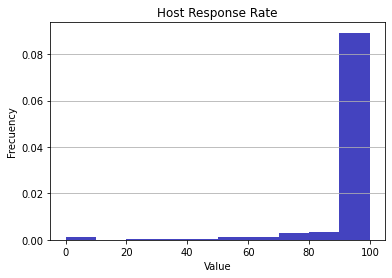

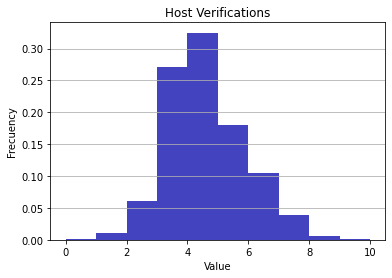

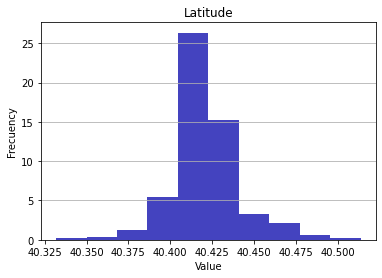

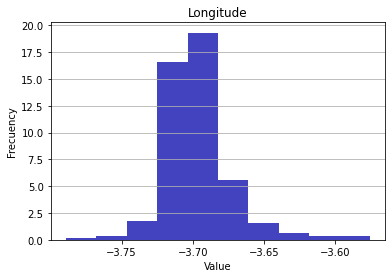

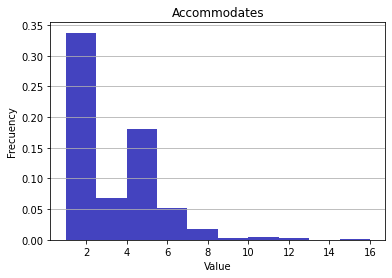

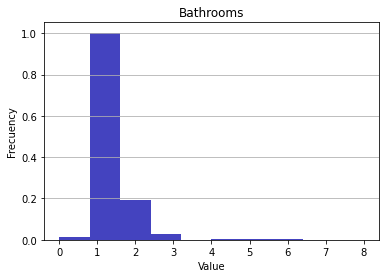

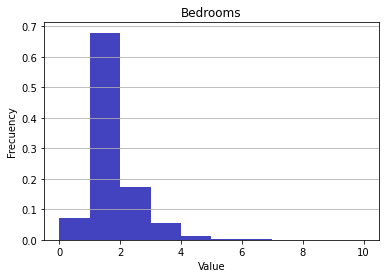

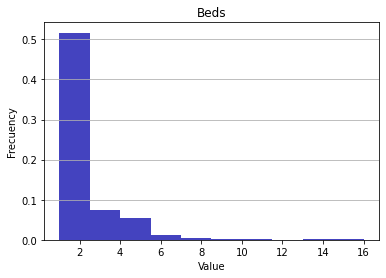

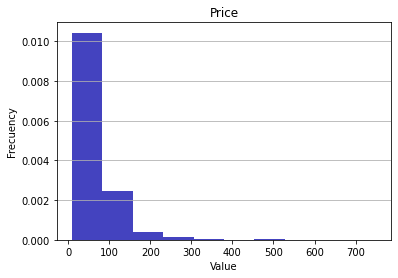

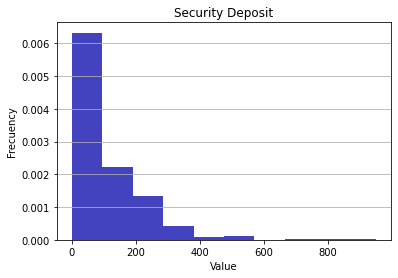

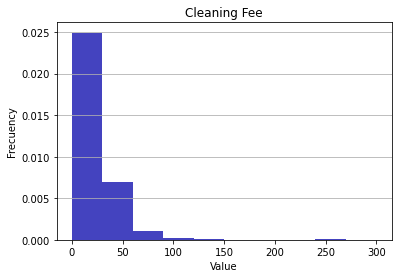

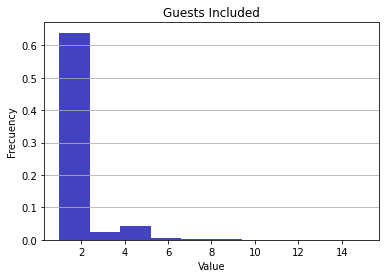

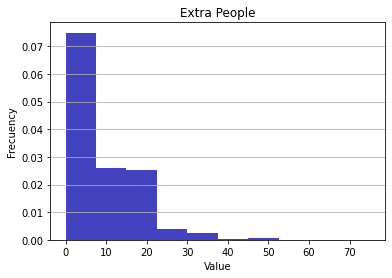

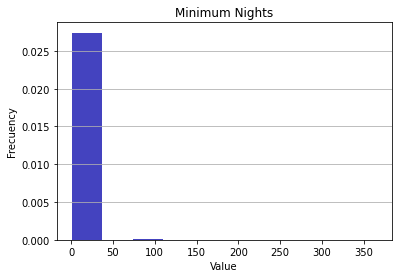

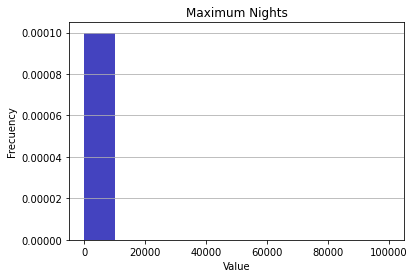

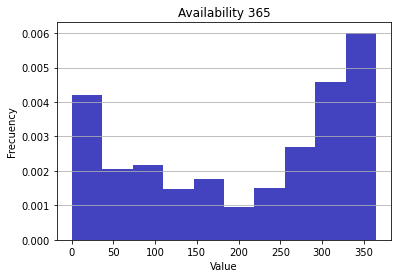

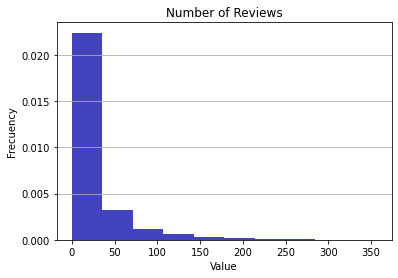

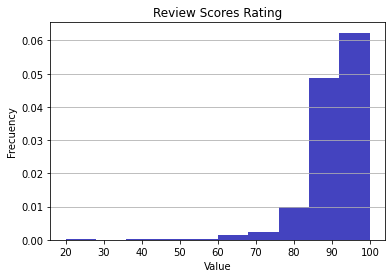

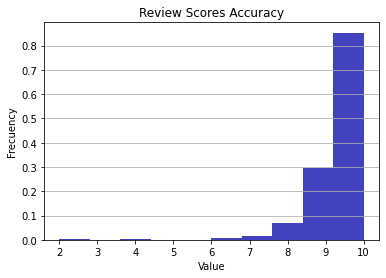

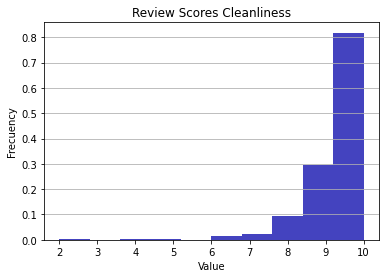

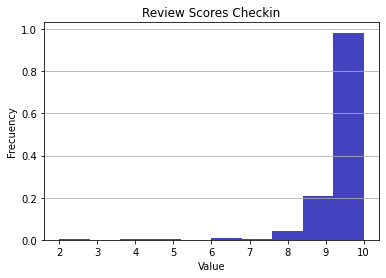

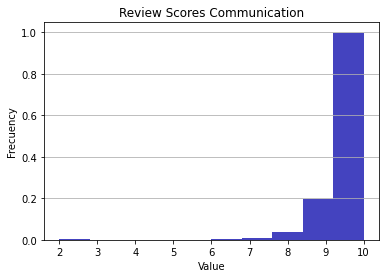

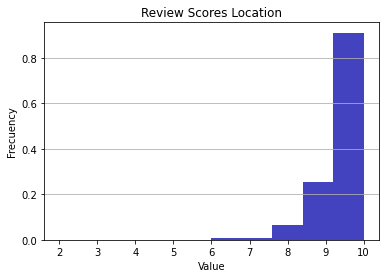

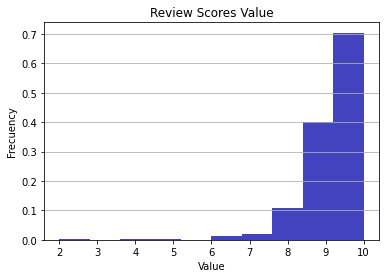

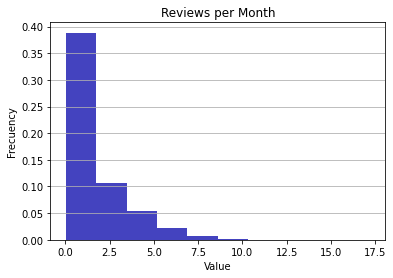

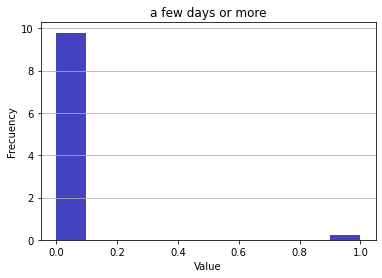

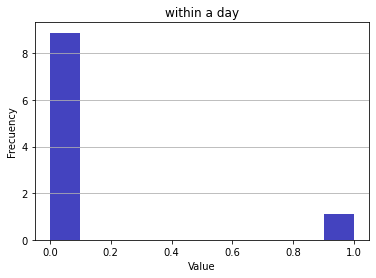

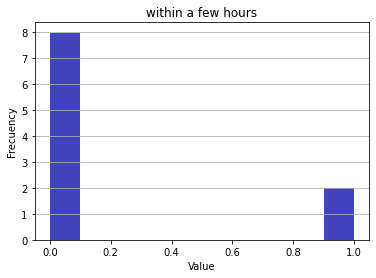

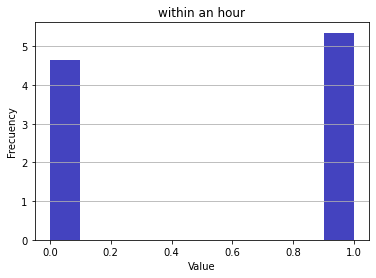

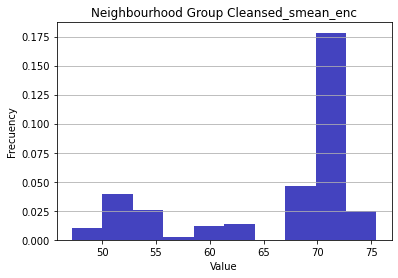

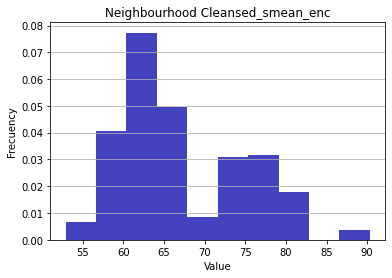

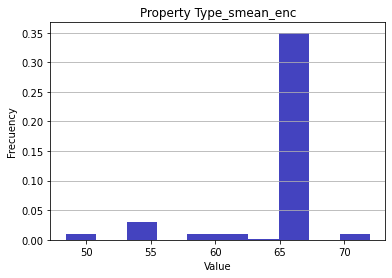

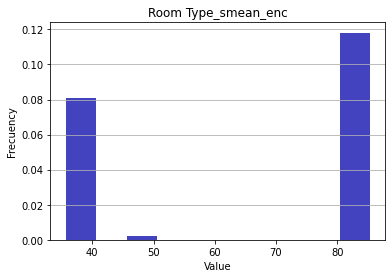

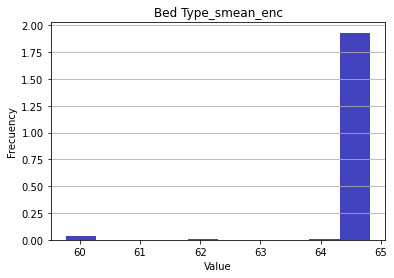

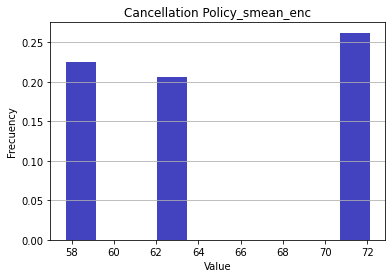

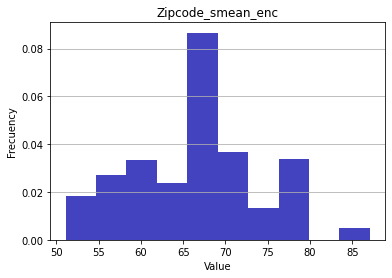

In [63]:
n = 0
for column in data.columns:
    plt.hist(x=data[column], density = True, alpha= 0.75, color='#0504aa')
    n = n + 1
    plt.grid(axis='y')
    plt.xlabel('Value')
    plt.ylabel('Frecuency')
    plt.title(column)
    plt.show()

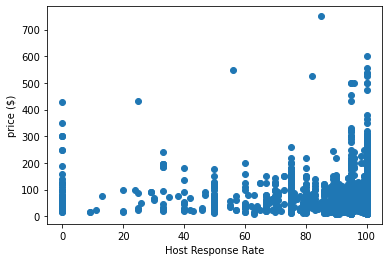

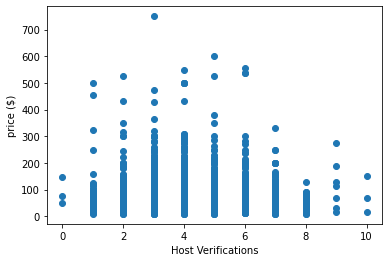

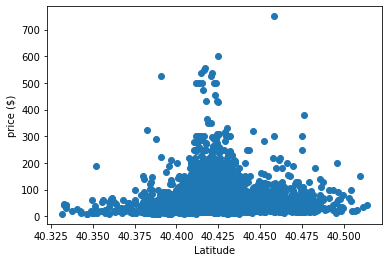

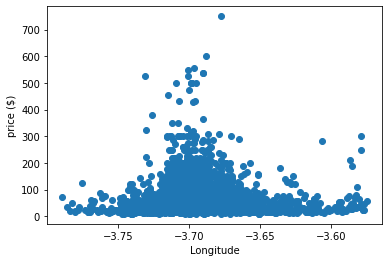

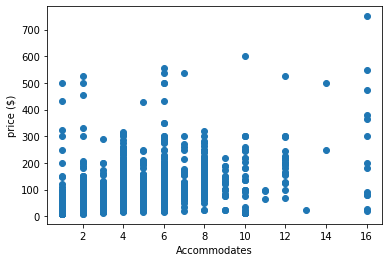

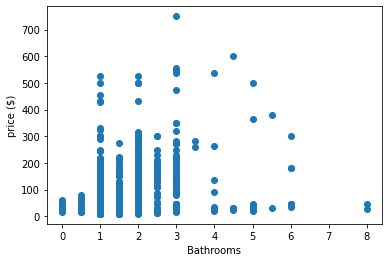

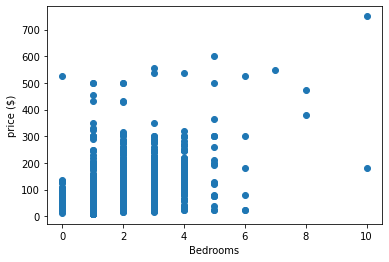

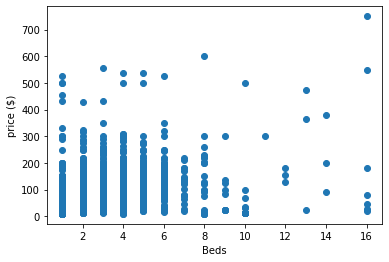

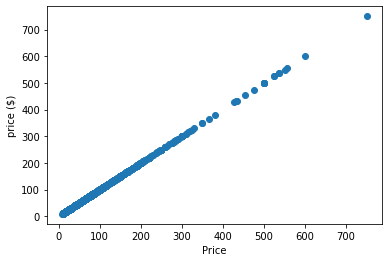

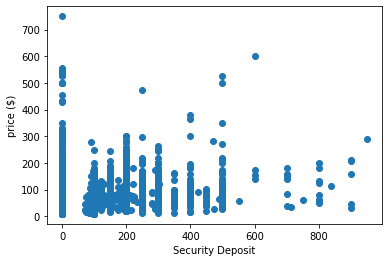

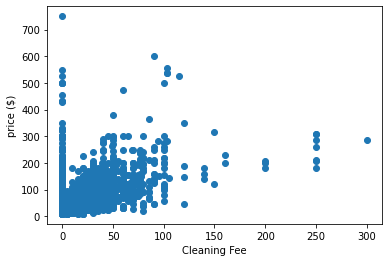

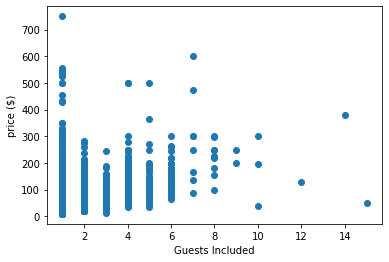

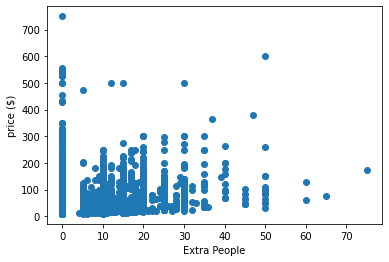

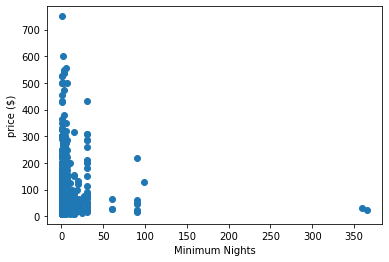

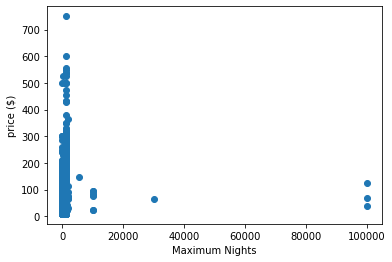

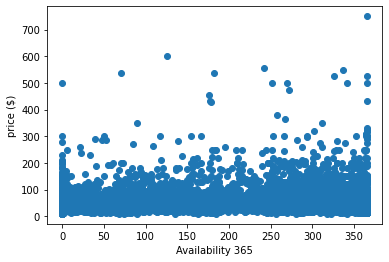

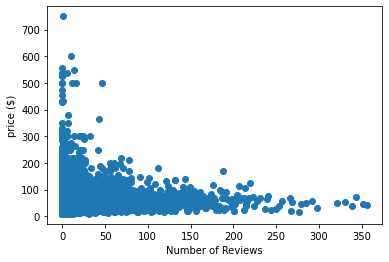

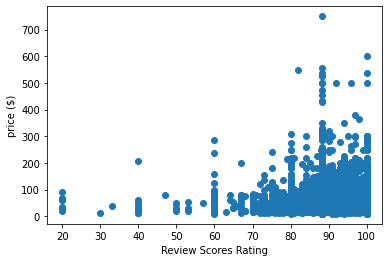

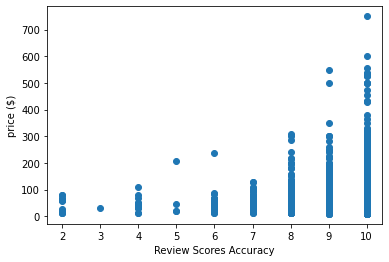

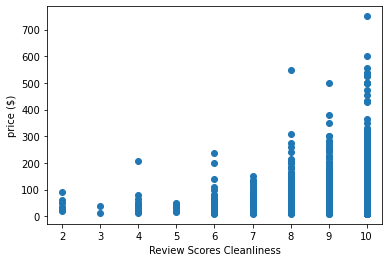

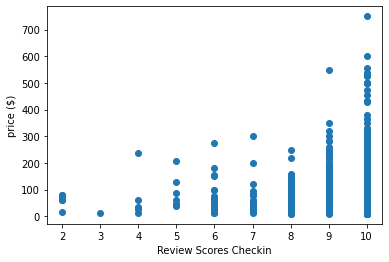

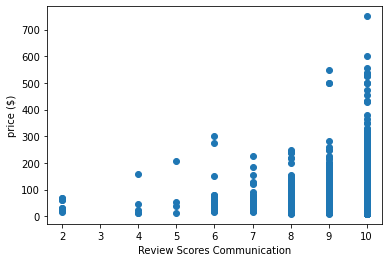

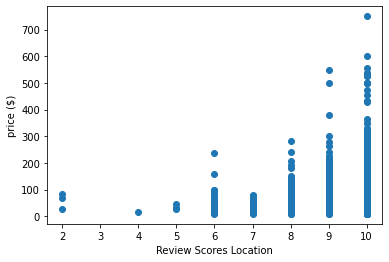

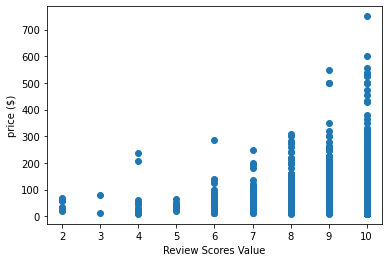

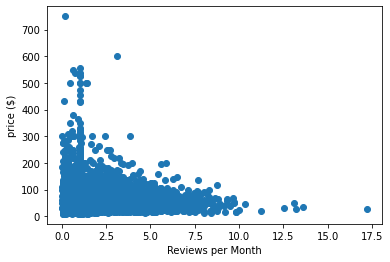

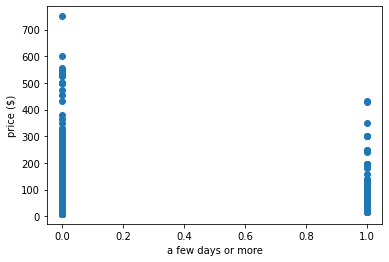

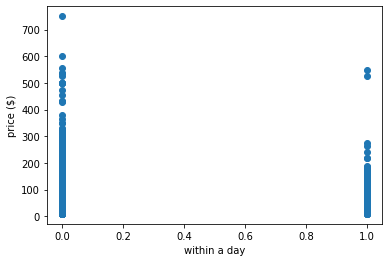

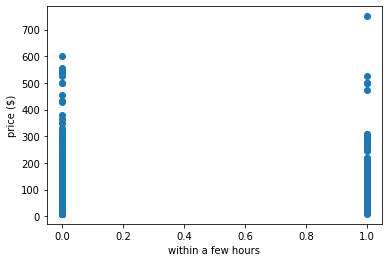

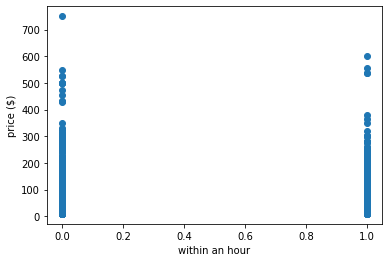

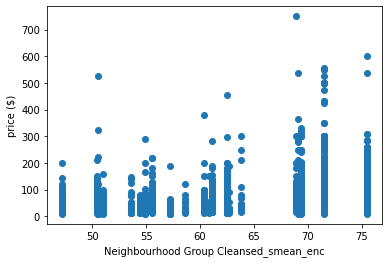

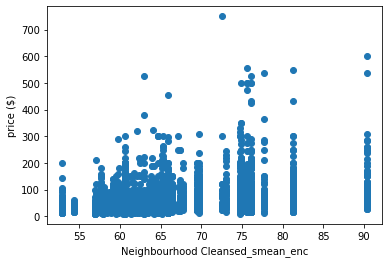

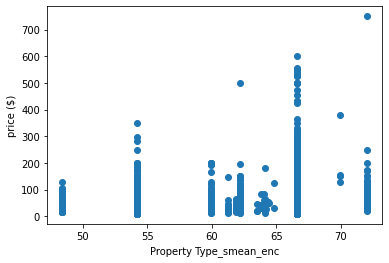

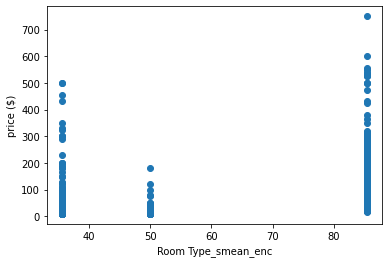

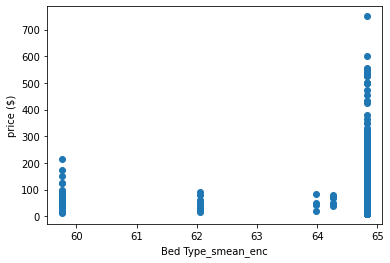

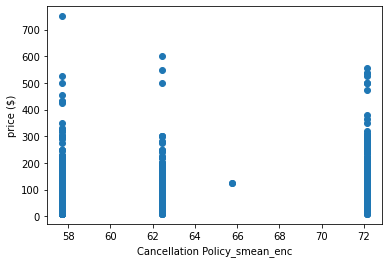

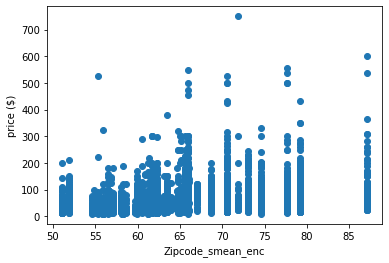

In [64]:
for column in data.columns:
    plt.scatter(x=data[column], y=data['Price'])
    plt.xlabel(column)
    plt.ylabel('price ($)')
    plt.show()

Veamos como correlaciona la diferentes variables entre ellas

/tmp/ipykernel_45562/461963522.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


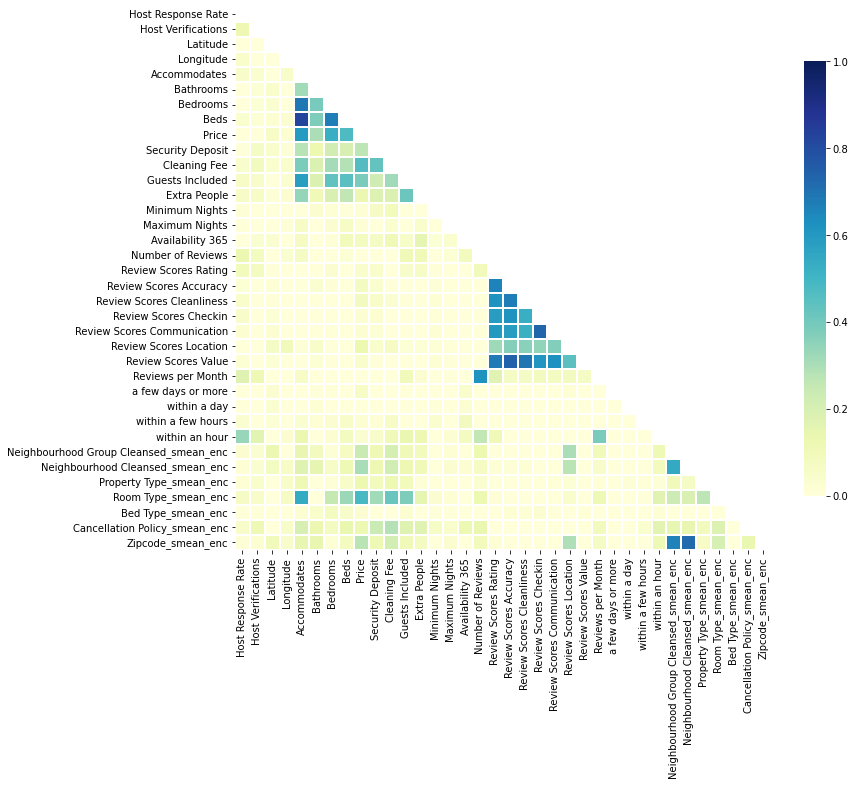

In [65]:
import seaborn as sns

#Compute the correlation matrix
corr = np.abs(data).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Se puede apreciar que una alta correlacion con la variable Acommodates, Beds, Number of Reviews, las variables Reviews score y la variable zipcode, realizaremos un drop de esta variables.

In [66]:
data.drop(['Review Scores Rating', 'Review Scores Accuracy','Accommodates',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Beds', 'Zipcode_smean_enc'], axis = 1, inplace = True)

/tmp/ipykernel_45562/461963522.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


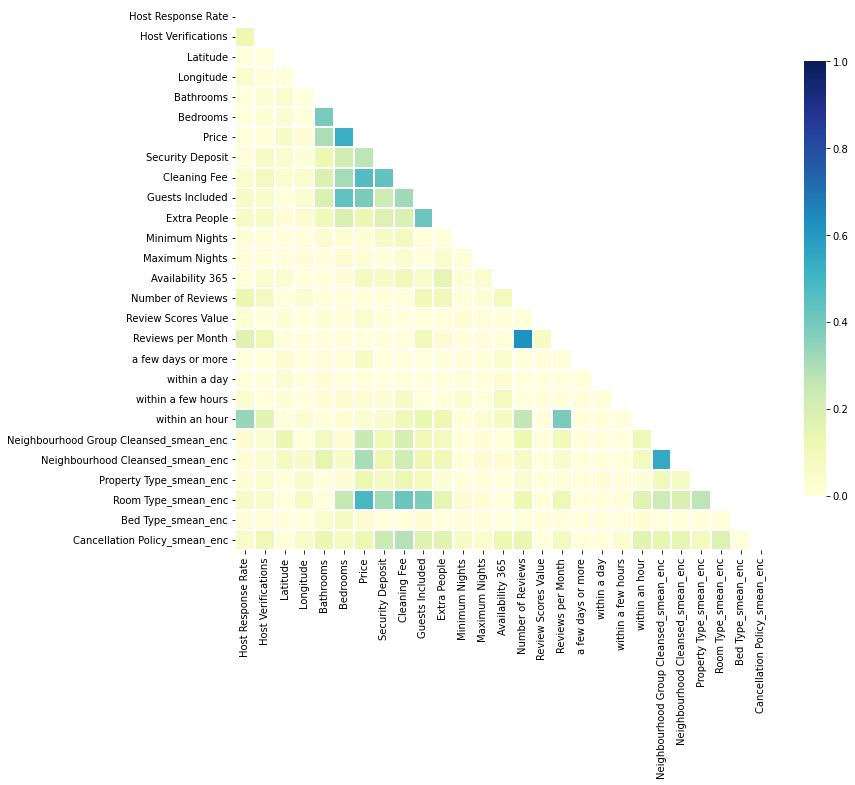

In [67]:
import seaborn as sns

#Compute the correlation matrix
corr = np.abs(data).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [68]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Response Rate,5287.0,94.713571,14.450103,0.000000,94.713571,100.000000,100.000000,100.000000
Host Verifications,5287.0,4.112540,1.305859,0.000000,3.000000,4.000000,5.000000,10.000000
Latitude,5287.0,40.420606,0.020185,40.331888,40.410064,40.418458,40.428072,40.513552
Longitude,5287.0,-3.697123,0.022967,-3.789276,-3.707771,-3.701456,-3.693688,-3.575142
Bathrooms,5287.0,1.244373,0.581557,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,5287.0,1.281634,0.811575,0.000000,1.000000,1.000000,1.000000,10.000000
Price,5287.0,64.568375,52.528862,9.000000,30.000000,50.000000,80.000000,750.000000
Security Deposit,5287.0,78.165689,116.186124,0.000000,0.000000,0.000000,150.000000,950.000000
Cleaning Fee,5287.0,16.706639,22.389156,0.000000,0.000000,10.000000,30.000000,300.000000
Guests Included,5287.0,1.566295,1.071817,1.000000,1.000000,1.000000,2.000000,15.000000


Eliminaremos los outliers en las siguientes columnas:
- Bathrooms -> Outliers mayores a 6
- Bedrooms -> Outliers mayores a 6
- Security Deposit -> Outliers mayores a 600
- Cleaning Fee -> Outliers mayores a 150
- Guests Included -> Outliers mayores a 9
- Extra People -> Outliers mayores a 75
- Maximum Nights -> Outliers mayores a 1500
- Minimum Nights -> Outliers mayores a 25
- Number of Reviews -> Outliers mayores a 325

In [69]:
data = data[data['Bathrooms']<=6]
data = data[data['Bedrooms']<=6]
data = data[data['Security Deposit']<=600]
data = data[data['Cleaning Fee']<=150]
data = data[data['Guests Included']<=9]
data = data[data['Extra People']<=75]
data = data[data['Maximum Nights']<=1500]
data = data[data['Minimum Nights']<=25]
data = data[data['Number of Reviews']<=325]
data.shape

(5178, 27)

In [70]:
data.columns

Index(['Host Response Rate', 'Host Verifications', 'Latitude', 'Longitude',
       'Bathrooms', 'Bedrooms', 'Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Minimum Nights', 'Maximum Nights',
       'Availability 365', 'Number of Reviews', 'Review Scores Value',
       'Reviews per Month', 'a few days or more', 'within a day',
       'within a few hours', 'within an hour',
       'Neighbourhood Group Cleansed_smean_enc',
       'Neighbourhood Cleansed_smean_enc', 'Property Type_smean_enc',
       'Room Type_smean_enc', 'Bed Type_smean_enc',
       'Cancellation Policy_smean_enc'],
      dtype='object')

Vamos a realizar un selección de características mediante método embedded de filtrado y Lasso

/home/javier/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/javier/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


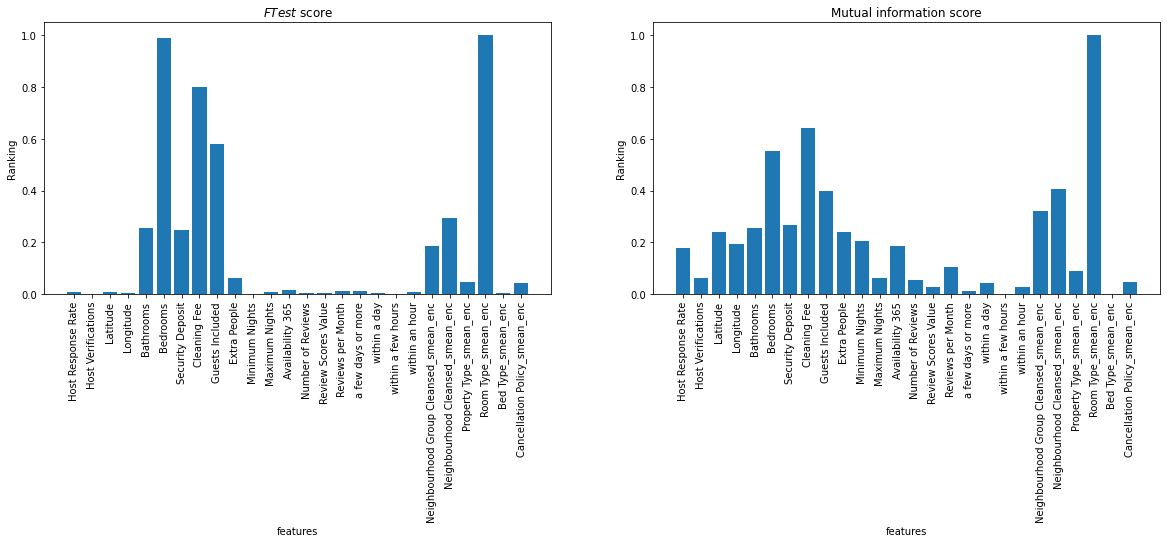

In [71]:
# convertimos el DataFrame al formato necesario para scikit-learn

data_value = data.values
y = data_value[:,6:7]  # nos quedamos con la 1ª columna, price
X = np.concatenate((data_value[:,0:6],data_value[:,7:]), axis=1, out=None) # nos quedamos con el resto
scalerX = preprocessing.StandardScaler().fit(X)
scalerY = preprocessing.StandardScaler().fit(y)

X = scalerX.transform(X)
y = scalerY.transform(y)

feature_names = data.columns[0:6].append(data.columns[7:])


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$FTest$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

best mean cross-validation score: -0.498
best parameters: {'alpha': 0.001}


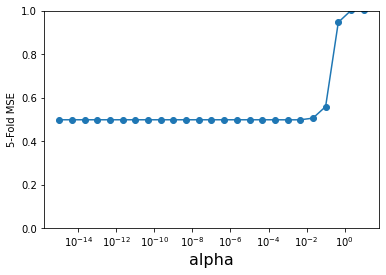

In [72]:
#Aplicamos Lasso con gridSearch

alpha_vector = np.logspace(-15,1,25)
param_grid = {'alpha': alpha_vector}
grid0 = GridSearchCV(Lasso(max_iter=30000), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid0.fit(X, y)
print("best mean cross-validation score: {:.3f}".format(grid0.best_score_))
print("best parameters: {}".format(grid0.best_params_))

scores = -1*np.array(grid0.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')
plt.ylim((0, 1))
plt.show()

In [73]:
# Entrenamos el modelo y revisamos el peso de las variables
alpha = grid0.best_params_['alpha']
lasso = Lasso(alpha = alpha, max_iter=30000).fit(X,y)
w = lasso.coef_
norm_w2 = np.dot(w,w.T)
    
# predicción
y_hat = lasso.predict(X)

# error
error_test = np.mean(np.power(y - y_hat,2)) 
coef_names = ['w' + str(i) + ': ' for i in range(0,25)]

for f,wi in zip(coef_names,w):
    print(f,wi)

w0:  -0.004808282798569941
w1:  -0.011904142649481374
w2:  0.002804702242861406
w3:  -6.334542900552696e-05
w4:  0.12585919544279067
w5:  0.28085826437815575
w6:  -0.003978791467123286
w7:  0.13221623432582694
w8:  0.09866960565551594
w9:  -0.0627775038385925
w10:  -0.06324779936675053
w11:  -0.0
w12:  0.08245135929063
w13:  -0.03638675734925928
w14:  0.07045366674402732
w15:  -0.06888593266426883
w16:  0.0456281643235346
w17:  -0.04721923126347631
w18:  -0.050879032737695604
w19:  -0.06702970122290934
w20:  0.05788385480430568
w21:  0.15026879435066332
w22:  0.005681061909275034
w23:  0.3370319542063092
w24:  0.011058954552034136


Según Lasso, F-testScore y multinfo todas las varaibles tienen algún tipo de impacto en la variable dependiente, así pues se mantienen en el modelo

A continuación vamos a unir los dataset de codificación onehot de data_Amenities_enc y data_Features_enc  . No se han incluido antes para no complejizar el análisis de características (+ 100 variables), suponenmos que su naturaleza y la información de proporcionada es los suficientemente diferente e intersante para incluir en nuestro modelo.

In [74]:
data = data.join(data_Features_enc)
data = data.join(data_Amenities_enc)
data.shape

(5178, 101)

In [75]:
data.columns

Index(['Host Response Rate', 'Host Verifications', 'Latitude', 'Longitude',
       'Bathrooms', 'Bedrooms', 'Price', 'Security Deposit', 'Cleaning Fee',
       'Guests Included',
       ...
       'Pack ’n Play/travel crib_onehotenc', 'Washer / Dryer_onehotenc',
       'Outlet covers_onehotenc', 'Children’s books and toys_onehotenc',
       'Game console_onehotenc', 'Keypad_onehotenc', 'Baby bath_onehotenc',
       'Changing table_onehotenc', 'Children’s dinnerware_onehotenc',
       'Stair gates_onehotenc'],
      dtype='object', length=101)

Vamos a realizar un análisis rápido de correlación para ver si alguna variable supera 0.6 de correlación con otra.

In [76]:
d = np.abs(data).corr()

for column in d.columns:
    d = d[d[column]>=0.6]

print(d)

Empty DataFrame
Columns: [Host Response Rate, Host Verifications, Latitude, Longitude, Bathrooms, Bedrooms, Price, Security Deposit, Cleaning Fee, Guests Included, Extra People, Minimum Nights, Maximum Nights, Availability 365, Number of Reviews, Review Scores Value, Reviews per Month, a few days or more, within a day, within a few hours, within an hour, Neighbourhood Group Cleansed_smean_enc, Neighbourhood Cleansed_smean_enc, Property Type_smean_enc, Room Type_smean_enc, Bed Type_smean_enc, Cancellation Policy_smean_enc, Host Has Profile Pic_onehotenc, Requires License_onehotenc, Host Is Superhost_onehotenc, Host Identity Verified_onehotenc, Is Location Exact_onehotenc, Instant Bookable_onehotenc, Require Guest Profile Picture_onehotenc, Require Guest Phone Verification_onehotenc, TV_onehotenc, Internet_onehotenc, Wireless Internet_onehotenc, Air conditioning_onehotenc, Wheelchair accessible_onehotenc, Kitchen_onehotenc, Smoking allowed_onehotenc, Pets allowed_onehotenc, Doorman_oneho

No hay correlaciones mayores de 0.6 en nuestro dataset, así pues, nuestro modelo contará con 100 características para la parte NPL. Por otro lado, tenemos que comprobar los registros válidos de las imagenes para obtener, el dataset limpio para iniciar la fase de modelado

#### Análisis Imágenes para CNN

Primero vamos asignar en images_path si fue cargado o no

In [77]:
n=0
for i in images_paths:
    i.append(was_loaded[n])
    n += 1

In [78]:
df_images = pd.DataFrame(images_paths) #Creamos un dataset

In [79]:
data.shape

(5178, 101)

In [80]:
df_images.columns = ['index', 'url', 'dowloands'] #Añadimos nombres a las variables

In [81]:
#Eliminamos los valores NaN y las imagenes no cargadas
df_images = df_images[df_images['url'].notnull()]
df_images = df_images[df_images['dowloands'] == 1]

In [82]:
df_images

,index,url,dowloands
1,1,https://a0.muscache.com/im/pictures/1fa8b3c1-a...,1.0
3,3,https://a0.muscache.com/im/pictures/137dd27c-3...,1.0
5,5,https://a0.muscache.com/im/pictures/850bb391-d...,1.0
6,6,https://a0.muscache.com/im/pictures/54256557-6...,1.0
7,7,https://a0.muscache.com/im/pictures/0b75ef20-1...,1.0
...,...,...,...
5595,5595,https://a0.muscache.com/im/pictures/245ebc83-0...,1.0
5596,5596,https://a0.muscache.com/im/pictures/d88b96df-0...,1.0
5597,5597,https://a0.muscache.com/im/pictures/33acce73-2...,1.0
5598,5598,https://a0.muscache.com/im/pictures/4436582b-3...,1.0


In [83]:
#Realizamos un merge los dos data frame para quedarnos con los datos válidos
data = pd.merge(data, df_images, left_index=True, right_index=True)

In [84]:
data

,Host Response Rate,Host Verifications,Latitude,Longitude,Bathrooms,Bedrooms,Price,Security Deposit,Cleaning Fee,Guests Included,...,Children’s books and toys_onehotenc,Game console_onehotenc,Keypad_onehotenc,Baby bath_onehotenc,Changing table_onehotenc,Children’s dinnerware_onehotenc,Stair gates_onehotenc,index,url,dowloands
1,94.713571,3,40.417695,-3.677590,1.0,1.0,36.0,100.0,0.0,1,...,0,0,0,0,0,0,0,1,https://a0.muscache.com/im/pictures/1fa8b3c1-a...,1.0
3,100.000000,5,40.409855,-3.703289,1.0,1.0,34.0,0.0,0.0,1,...,0,0,0,0,0,0,0,3,https://a0.muscache.com/im/pictures/137dd27c-3...,1.0
5,100.000000,6,40.415769,-3.705385,1.0,1.0,55.0,200.0,25.0,2,...,0,0,0,0,0,0,0,5,https://a0.muscache.com/im/pictures/850bb391-d...,1.0
6,100.000000,5,40.380594,-3.731574,2.0,1.0,12.0,300.0,0.0,1,...,0,0,0,0,0,0,0,6,https://a0.muscache.com/im/pictures/54256557-6...,1.0
7,100.000000,3,40.389052,-3.700125,1.0,1.0,20.0,0.0,0.0,1,...,0,0,0,0,0,0,0,7,https://a0.muscache.com/im/pictures/0b75ef20-1...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,100.000000,4,40.399131,-3.702170,1.0,1.0,25.0,0.0,0.0,1,...,0,0,0,0,0,0,0,5595,https://a0.muscache.com/im/pictures/245ebc83-0...,1.0
5596,94.713571,4,40.422652,-3.685307,1.0,1.0,70.0,0.0,20.0,2,...,0,0,0,0,0,0,0,5596,https://a0.muscache.com/im/pictures/d88b96df-0...,1.0
5597,100.000000,5,40.409604,-3.694229,1.0,1.0,65.0,250.0,0.0,2,...,0,0,0,0,0,0,0,5597,https://a0.muscache.com/im/pictures/33acce73-2...,1.0
5598,97.000000,3,40.420827,-3.701070,2.0,1.0,50.0,0.0,10.0,1,...,0,0,0,0,0,0,0,5598,https://a0.muscache.com/im/pictures/4436582b-3...,1.0


In [85]:
data.drop(['index', 'url', 'dowloands'], axis = 1, inplace = True) #Eliminamos las columna no utilies

In [86]:
data.shape

(4297, 101)

In [87]:
#Creamos una lista con los valores a eliminar en el array de imagenes
drop_list = []

for i in range(0,loaded_images.shape[0]):
    if i not in data.index:
        drop_list.append(i)

In [88]:
loaded_images.shape

(5600, 224, 224, 3)

In [89]:
#Eliminamos los arrays de imagenes nan y sin descarga
loaded_images = np.delete(loaded_images, drop_list, axis=0)


In [90]:
loaded_images.shape

(4297, 224, 224, 3)

In [91]:
data_value = data.values
y = data_value[:,6:7]  # Separamos la columna de la variable a predecir, price
X = np.concatenate((data_value[:,0:6],data_value[:,7:]), axis=1, out=None) # nos quedamos con el resto como entrada del modelo
X_img = loaded_images/255. #Estandarizamos las imagenes
scalerX = preprocessing.StandardScaler().fit(X) #Creamos el objeto de estandarización mediante la clase StandardScaler
X = scalerX.transform(X) #Estandarizamos el resto de variables
scalerY = preprocessing.MinMaxScaler().fit(y) #Creamos el objeto de estandarización mediante la clase MinMaxScaler
y = scalerY.transform(y) #Estandarizamos la variable objetivo

Ya tenemos preparados nuestro datos para entrenar los modelos de redes neuronales, pero antes, vamos preparar el dataset de train para tener listo para testar nuestros modelos

### Preparando los dataframe de test

In [111]:
#Cargamos los datos de test
test = pd.read_csv('./test.csv', sep=';', decimal='.')

In [112]:
images_paths_test = []
for i, img_url in enumerate(test['Thumbnail Url']):
  images_paths_test.append([i, img_url])

In [113]:
loaded_images_test = np.zeros((len(images_paths_test), 224, 224, 3), dtype=np.uint8)

was_loaded_test = np.zeros(len(images_paths_test))

In [114]:
with concurrent.futures.ProcessPoolExecutor() as executor:


    for (img, idx) in tqdm(executor.map(get_image, images_paths_test), total=len(images_paths_test)):

        if img is not None:
            loaded_images_test[idx] = img
            was_loaded_test[idx] = 1
        else:
            was_loaded_test[idx] = 0

print('Finished!')
print(f'Number of images loaded: {sum(was_loaded_test)}/{len(images_paths_test)}')

100%|███████████████████████████████████████| 2400/2400 [00:30<00:00, 79.03it/s]


Finished!
Number of images loaded: 1919.0/2400


In [115]:
np.save('images_test.npy', loaded_images_test)
np.save('was_loaded_test.npy', was_loaded_test)

Realizamos las mismas transformaciones que en Dataframe de Data

In [116]:
test.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Thumbnail Url',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Street',
       'Neighbourhood', 'State', 'Market',
       'Smart Location', 'Country Code', 
       'Calendar Updated',
       'Has Availability', 'Availability 30', 'Availability 60',
       'Availability 90', 'Calendar last Scraped',
       'First Review', 'Last Review','Square Feet', 'Weekly Price','Monthly Price',
       'License', 'Jurisdiction Names',
       'Calculated host listings count',
       'Geolocation'], axis = 1, inplace = True)

In [117]:
test= test[test['Country']=='Spain']
test= test[test['City']=='Madrid']
test.drop(['Country', 'City'], axis = 1, inplace = True)

In [118]:
test['SumScore'] = (test['Review Scores Accuracy']+test['Review Scores Cleanliness']+
                   test['Review Scores Checkin']+test['Review Scores Communication']
                    +test['Review Scores Location']+test['Review Scores Value']
                   )/60*100
test['Review Scores Rating'].fillna(test['SumScore'][0], inplace=True)
test.drop(['SumScore'], axis=1, inplace=True)

In [119]:
test.drop(['Review Scores Rating', 'Review Scores Accuracy','Accommodates',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Beds', 'Zipcode'], axis = 1, inplace = True)

In [120]:
test = test[test.Price.notnull()]

In [121]:
test['Review Scores Value'].fillna(data['Review Scores Value'].mode()[0], inplace=True)
test['Cleaning Fee'] = test['Cleaning Fee'].apply(lambda x: 0 if (pd.isnull(x)) else x)
test['Security Deposit'] = test['Security Deposit'].apply(lambda x: 0 if (pd.isnull(x)) else x)
test['Bathrooms'].fillna(data['Bathrooms'].mode()[0], inplace=True)
test['Bedrooms'].fillna(data['Bedrooms'].mode()[0], inplace=True)
test['Reviews per Month'].fillna(data['Reviews per Month'].mode()[0], inplace=True)
test['Host Response Rate'].fillna(data['Host Response Rate'].mean(), inplace=True)

In [122]:
test['Host Verifications'] = test['Host Verifications'].apply(lambda x: 0 if (pd.isnull(x)) else x.count(',')+1)

In [123]:
#Revisar
host_response_encoder_test = pd.get_dummies(test['Host Response Time'])
test = test.join(host_response_encoder_test)
test.drop(['Host Response Time'], axis=1, inplace=True)

In [124]:
test['Amenities'] = test['Amenities'].apply(lambda x: '0' if (pd.isnull(x)) else x)

df_Amenities = test['Amenities'].str.split(',', n = 1000, expand = False)

df_Amenities = pd.DataFrame(df_Amenities)

for element in data.columns[35:]:
    element = element[:-10]
    df_Amenities[element + '_onehotenc'] = df_Amenities['Amenities'].map(lambda x: 1 if element in x else 0)

df_Amenities.drop(['Amenities'], axis = 1, inplace = True)
    
if '0_onehotenc' in df_Amenities.columns:
    df_Amenities.drop(['0_onehotenc'], axis = 1, inplace = True)

In [125]:
test['Features'] = test['Features'].apply(lambda x: '0' if (pd.isnull(x)) else x)

df_Features = test['Features'].str.split(',', n = 1000, expand = False)

df_Features = pd.DataFrame(df_Features)

for element in data.columns[27:35]:
    element = element[:-10]
    df_Features[element + '_onehotenc'] = df_Features['Features'].map(lambda x: 1 if element in x else 0)

df_Features.drop(['Features'], axis = 1, inplace = True)
    
if '0_onehotenc' in df_Features.columns:
    df_Features.drop(['0_onehotenc'], axis = 1, inplace = True)

In [126]:
test.drop(['Amenities', 'Features'], axis = 1, inplace = True)

In [127]:
#Definimos una función para los valores codificados
def cod_var(variable):
    values = dict_values_variables[variable]
    test.loc[:,(variable+'_smean_enc')] = test[variable].map(values)
    test[(variable+'_smean_enc')] = test[(variable+'_smean_enc')].apply(lambda x: mean_all if pd.isnull(x) else x)
    return test.drop([variable], axis = 1, inplace = True)

cod_var('Neighbourhood Group Cleansed')
cod_var('Neighbourhood Cleansed')
cod_var('Property Type')
cod_var('Room Type')
cod_var('Bed Type')
cod_var('Cancellation Policy')

In [128]:
test = test.join(data_Features_enc)
test = test.join(data_Amenities_enc)

In [129]:
for column in range(0, test.shape[1]):
    tasa_na = test[test.columns.values[column]].isnull().sum()/test.shape[0]
    if tasa_na > 0:
        test=test[test[test.columns[column]].notnull()]

In [130]:
n=0
for i in images_paths_test:
    i.append(was_loaded_test[n])
    n += 1

In [131]:
df_images_test = pd.DataFrame(images_paths_test)

In [132]:
df_images_test.columns = ['index', 'url', 'dowloands']
df_images_test = df_images_test[df_images_test['url'].notnull()]
df_images_test = df_images_test[df_images_test['dowloands'] == 1]
test = pd.merge(test, df_images_test, left_index=True, right_index=True)
test.drop(['index', 'url', 'dowloands'], axis = 1, inplace = True)

In [133]:
drop_list_test = []
for i in range(0,loaded_images_test.shape[0]):
    if i not in test.index:
        drop_list_test.append(i)

In [134]:
loaded_images_test = np.delete(loaded_images_test, drop_list_test, axis=0)

In [135]:
test.shape

(1722, 101)

In [136]:
data.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [137]:
test_value = test.values
y_test = test_value[:,6:7] 
X_test = np.concatenate((test_value[:,0:6],test_value[:,7:]), axis=1, out=None)
X_img_test = loaded_images_test/255.
# Escalamos con los mismos objetos creados con el dataset de train
X_test = scalerX.transform(X_test)
y_test = scalerY.transform(y_test) 

### Guardamos los datos

In [3]:
np.save('X_data.npy', X)
np.save('y_data.npy', y)
np.save('X_img_data.npy', X_img)

NameError: name 'X' is not defined

In [138]:
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('X_img_test.npy', X_img_test)

### Carga de Datos

In [3]:
X = np.load('X_data.npy')
y = np.load('y_data.npy')
X_img = np.load('X_img_data.npy')

In [3]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_img_test = np.load('X_img_test.npy')

### Modelos

In [2]:
import numpy as np
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model

In [4]:
np.random.seed(42)
#Separamos los datos para validar los modelos
(X_train, X_val, X_img_train, X_img_val, y_train, y_val) = train_test_split(X, X_img, y, test_size=0.2, random_state=42)

A continuación vamos a trabajar 4 modelos distintos, con arquitecturas similares para ver la diferencia entre diferentes tipos de entrenamiento.
1. El primer modelo entrenará tanto la CCN como la MLP a la vez.
2. El segundo modelo entrenara primero las redes por separado para posteriormente entrenarlas conjuntamente.
3. El tercer modelo aprovechara el aprendizaje del modelo VGG16 en la parte de la CNN para optimizar el trabajo de la red.
4. El cuarto modelo tendrá más de una MLP para trabajar con los datos codificados one shot por ramas de la red.

#### Primer Modelo - Entrenamiento en conjunto
El primer modelo entrenará ambas partes a la vez.

In [6]:
#Declaramos las entradas de los dos submodelos
inputA = Input(shape=(100,))
inputB = Input(shape=(224, 224, 3))

#Creamos el modelo mlp. Aumentamos la dimesionalidad para posteriormente reducir a 64
x_data = Dense(512, activation="relu")(inputA)
x_data = Dense(256, activation="relu")(x_data)
x_data = Dropout(0.25)(x_data)
x_data = Dense(128, activation="relu")(x_data)
x_data = Dropout(0.25)(x_data)
x_data = Dense(64, activation="relu")(x_data)
x_data = Model(inputs=inputA, outputs = x_data)

#Creamos el modelo CNN realizando Convoluciones => Bachnormalitazion => MaxPooling => Dropout reduciendo las dimensiones antes del flatten
x_img = Conv2D(32, [3, 3], activation='relu')(inputB)
X_img = BatchNormalization(-1)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Dropout(0.25)(x_img)
x_img = Conv2D(64, [7, 7], activation='relu')(x_img)
X_img = BatchNormalization(-1)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Dropout(0.25)(x_img)
x_img = Conv2D(32, [5, 5], activation='relu')(x_img)
X_img = BatchNormalization(-1)
x_img = MaxPooling2D(pool_size=(2, 2))(x_img)
x_img = Dropout(0.25)(x_img)
x_img = Flatten()(x_img)
x_img = Dense(256, activation='relu')(x_img)
x_img = Dense(128, activation='relu')(x_img)
x_img = Dropout(0.25)(x_img)
x_img = Dense(64, activation='relu')(x_img)
x_img = Model(inputs=inputB, outputs = x_img)

#Finalmente integramos ambas redes para unificar el entrenamiento y la salida
combined = Concatenate()([x_data.output, x_img.output])

z = Dense(128,activation='relu')(combined)
z = Dense(64,activation='relu')(combined)
z = Dropout(0.25)(z)
z = Dense(32,activation='relu')(z)
z = Dense(16,activation='relu')(z)
z = Dropout(0.25)(z)
z = Dense(1, activation = 'linear')(z)
        
model_1 = Model(inputs=[x_data.input, x_img.input], outputs=z)


2022-02-13 22:03:46.864494: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-13 22:03:47.047120: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-02-13 22:03:47.055309: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-02-13 22:03:47.059349: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.


In [7]:
#Se ha elegido Mean squared error como perdida y metrica. Como optimizador adams
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model_1.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)

In [8]:
#para poder realizar los entrenamiento se ha elegido 5 epocas un batch_size 8, estos parametros se han escogido por rendimiento de la máquina y optimización de tiempos de entrenamiento
model_1.fit(x=[X_train, X_img_train], y=y_train, 
          validation_data=([X_val, X_img_val], y_val),
          epochs=5, batch_size=8)

Epoch 1/5


2022-02-13 22:03:49.711930: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2069458944 exceeds 10% of free system memory.
2022-02-13 22:03:50.735695: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-02-13 22:03:51.364452: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f9728011940 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-13 22:03:51.364492: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-02-13 22:03:51.415952: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-02-13 22:03:51.460173: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if r

430/430 [==============================] - 375s 863ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 2/5
430/430 [==============================] - 367s 853ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 3/5
430/430 [==============================] - 365s 850ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/5
430/430 [==============================] - 365s 849ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 5/5
430/430 [==============================] - 365s 849ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0035 - val_mse: 0.0035


In [9]:
#Guardamos el modelo
model_1.save('path_to_model_1.h5')

In [10]:
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 32  0           ['conv2d[0][0]']                 
                                )                                                           

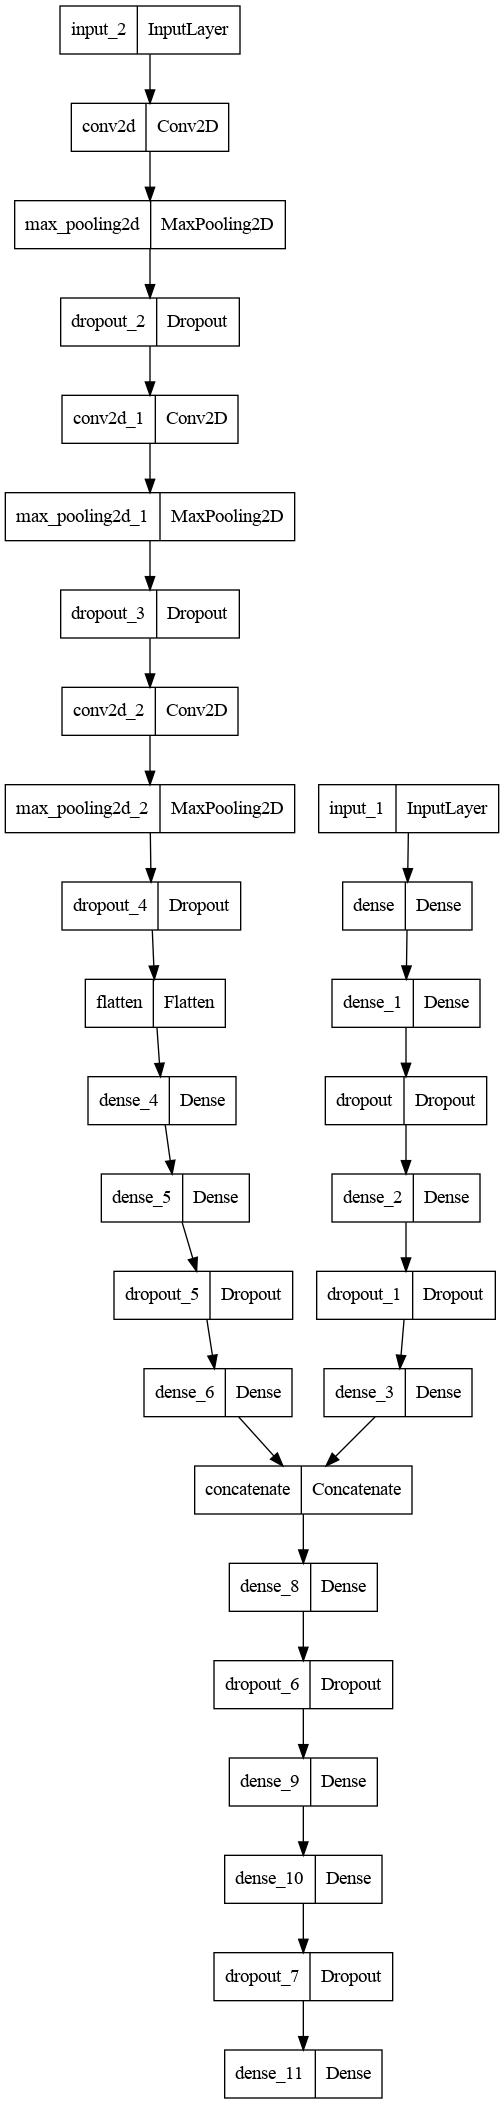

In [11]:
plot_model(model_1)

#### Segundo Modelo - Entrenamiento por separado
Este modelo entrenará cada rama por separado para pasar a un modelo en conjunto

In [12]:
#Estructura similar al modelo anterior para poder comparar el rendimiento en entrenamientos
def create_mlp(regress=False):
    model = Sequential()
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation="relu"))
    
    if regress:
        model.add(Dense(1, activation="linear"))
    return model

def create_cnn(regress=False):
    model = Sequential()
    model.add(Conv2D(32, [3, 3], activation='relu'))
    model.add(BatchNormalization(-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, [7, 7], activation='relu'))
    model.add(BatchNormalization(-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, [5, 5], activation='relu'))
    model.add(BatchNormalization(-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
              
    if regress:
        model.add(Dense(1, activation="linear"))
              
    return model

mlp = create_mlp()
cnn = create_cnn()

In [13]:
#Compilamos y entrenamos los modelos
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)

mlp.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)
cnn.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)

In [14]:
mlp.fit(x=X_train, y=y_train, 
          validation_data=(X_val, y_val),
          epochs=5, batch_size=8)

Epoch 1/5
430/430 [==============================] - 3s 4ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 2/5
430/430 [==============================] - 1s 2ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/5
430/430 [==============================] - 1s 2ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/5
430/430 [==============================] - 1s 2ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 5/5
430/430 [==============================] - 1s 2ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0040 - val_mse: 0.0040


In [15]:
cnn.fit(x=X_img_train, y=y_train, 
          validation_data=(X_img_val, y_val),
          epochs=5, batch_size=8)

Epoch 1/5
430/430 [==============================] - 491s 1s/step - loss: 0.3148 - mse: 0.3148 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 2/5
430/430 [==============================] - 483s 1s/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 3/5
430/430 [==============================] - 483s 1s/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 4/5
430/430 [==============================] - 483s 1s/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 5/5
430/430 [==============================] - 486s 1s/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0145 - val_mse: 0.0145


In [16]:
#Unimos los modelos y volvemos a entrenar
combined = Concatenate()([mlp.output, cnn.output])

z = Dense(128,activation='relu')(combined)
z = Dense(64,activation='relu')(z)
z = Dropout(0.25)(z)
z = Dense(32,activation='relu')(z)
z = Dense(16,activation='relu')(z)
z = Dropout(0.25)(z)
z = Dense(1, activation = 'linear')(z)
        
model_2 = Model(inputs=[mlp.input, cnn.input], outputs=z)

In [17]:
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model_2.compile(loss="mse", optimizer=opt, metrics = ['mse'], jit_compile=True)

In [18]:
model_2.fit(x=[X_train, X_img_train], y=y_train, 
          validation_data=([X_val, X_img_val], y_val),
          epochs=5, batch_size=8)

Epoch 1/5
430/430 [==============================] - 490s 1s/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 2/5
430/430 [==============================] - 481s 1s/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 3/5
430/430 [==============================] - 480s 1s/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 4/5
430/430 [==============================] - 480s 1s/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 5/5
430/430 [==============================] - 482s 1s/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0041 - val_mse: 0.0041


Aumenta el rendimiento en entrenamiento y mejora resultados, vamos a probar a aumnentar el nº epochs para ver si mejora la pérdida

In [19]:
model_2.save('path_to_model_2.h5')

In [20]:
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_3_input (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 222, 222, 32  896         ['conv2d_3_input[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 222, 222, 32  128        ['conv2d_3[0][0]']               
 rmalization)                   )                                                           

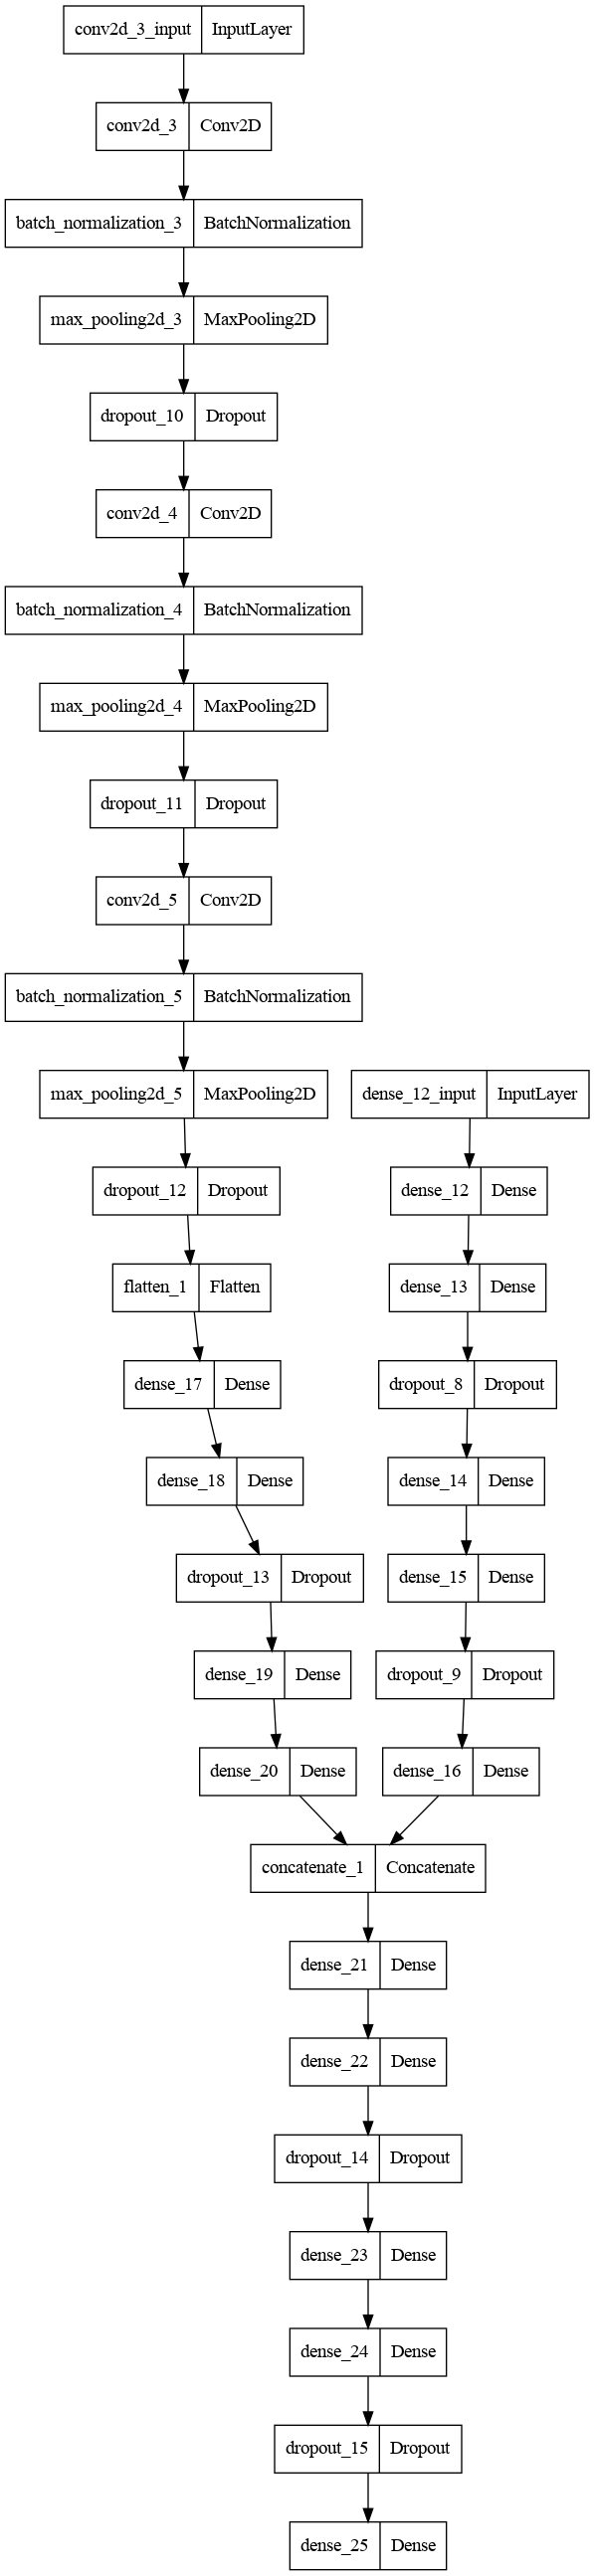

In [21]:
plot_model(model_2)

#### Tercer Modelo - Transfer learning

En este modelo vamos realizar transfer learning de la modelo VGG16

In [8]:
#Cargamos el modelo VGG16
base_model = VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=X_img_train[0].shape,
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

2022-02-14 19:11:57.598754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [150]:
#Declaramos las entradas de los dos submodelos
inputA = Input(shape=(100,))

#Creamos el modelo mlp
x_data = Dense(512, activation="relu")(inputA)
x_data = Dense(256, activation="relu")(x_data)
x_data = Dropout(0.25)(x_data)
x_data = Dense(128, activation="relu")(x_data)
x_data = Dropout(0.25)(x_data)
x_data = Dense(64, activation="relu")(x_data)
x_data = Model(inputs=inputA, outputs = x_data)

#Creamos el modelo CNN
layer_pool = GlobalAveragePooling2D()
flatten = Flatten()
dense_1 = Dense(256, activation='relu')
dense_2 = Dense(128, activation='relu')
dropout_3 = Dropout(0.25)
dense_4 = Dense(64, activation='relu')
x_img = Sequential([
    base_model,
    flatten,
    dense_1,
    dense_2,
    dropout_3,
    dense_4
])

combined = Concatenate()([x_data.output, x_img.output])

z = Dense(128,activation='relu')(combined)
z = Dense(64,activation='relu')(z)
z = Dropout(0.25)(z)
z = Dense(32,activation='relu')(z)
z = Dense(16,activation='relu')(z)
z = Dropout(0.25)(z)
z = Dense(1, activation = 'linear')(z)
        
model_3 = Model(inputs=[x_data.input, x_img.input], outputs=z)

In [151]:
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model_3.compile(loss="mse", optimizer=opt, metrics = ['mse'], jit_compile=True)

In [152]:
model_3.fit(x=[X_train, X_img_train], y=y_train, 
          validation_data=([X_val, X_img_val], y_val),
          epochs=5, batch_size=8)

Epoch 1/5
430/430 [==============================] - 882s 2s/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 2/5
430/430 [==============================] - 877s 2s/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 3/5
430/430 [==============================] - 874s 2s/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 4/5
430/430 [==============================] - 874s 2s/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 5/5
430/430 [==============================] - 874s 2s/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0037 - val_mse: 0.0037


In [153]:
model_3.save('path_to_model_3.h5')

In [154]:
model_3.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 vgg16_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense_50 (Dense)               (None, 512)          51712       ['input_8[0][0]']                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['vgg16_input[0][0]']      

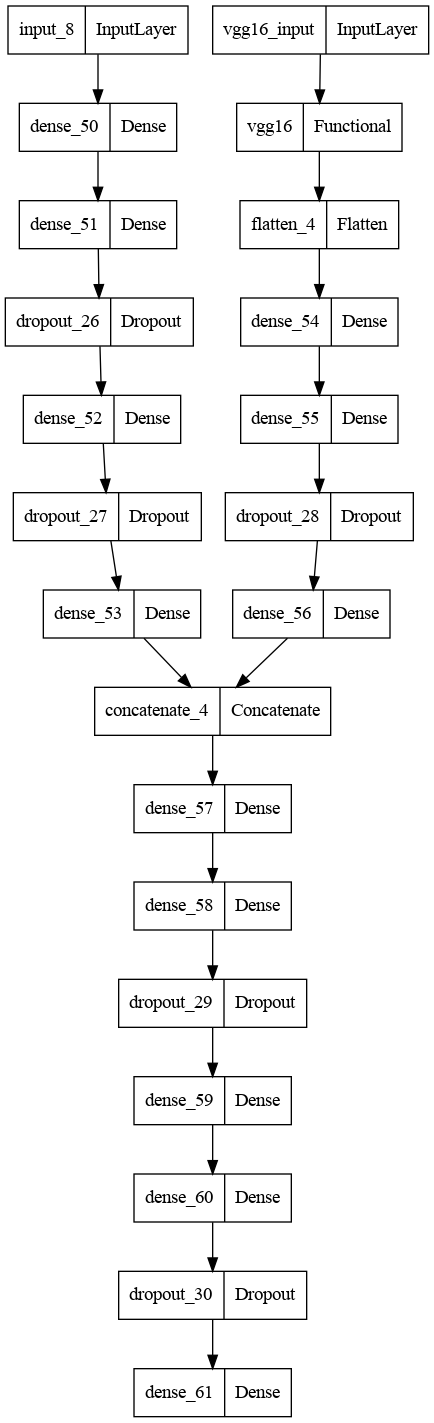

In [155]:
plot_model(model_3)

#### Modelo 4 - Modelo Complejo
En este modelo crearemos tres MLP y una CNN con un entrenamiento por separado

In [8]:
#Se crean tres data set de los datos numericos. El primero con los datos de todas las columnas no onehot, el segundo para el onehot de Features y el tercero para el one hot de Amenities
X_part_1 = X_train[:,:26]
X_part_2 = X_train[:,26:35]
X_part_3 = X_train[:,35:]
X_val_part_1 = X_val[:,:26]
X_val_part_2 = X_val[:,26:35]
X_val_part_3 = X_val[:,35:]

In [9]:
#En este modificamos la arquitectura, siguiendo la lógica de partir de más neuronas que variables y luego concentrando en menos neuronas
#El primero parte 128 para terminar con 32
# El segundo empieza con 64 y termina con 4
# El tercero empieza con 512 y termina con 16
def create_mlp_1(regress=False):
    model = Sequential()
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation="relu"))
    
    if regress:
        model.add(Dense(1, activation="linear"))
    return model

def create_mlp_2(regress=False):
    model = Sequential()
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))


    if regress:
        model.add(Dense(1, activation="linear"))
    return model

def create_mlp_3(regress=False):
    model = Sequential()
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation="relu"))
    
    if regress:
        model.add(Dense(1, activation="linear"))
    return model

def create_cnn(regress=False):
    model = Sequential()
    model.add(Conv2D(32, [3, 3], activation='relu'))
    model.add(BatchNormalization(-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, [7, 7], activation='relu'))
    model.add(BatchNormalization(-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, [5, 5], activation='relu'))
    model.add(BatchNormalization(-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
              
    if regress:
        model.add(Dense(1, activation="linear"))
              
    return model

mlp_1 = create_mlp_1()
mlp_2 = create_mlp_2()
mlp_3 = create_mlp_3()
cnn = create_cnn()

2022-02-14 13:42:12.558438: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#Se opta por el entrenamiento por separado en este caso
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)

mlp_1.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)
mlp_2.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)
mlp_3.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)
cnn.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)

In [12]:
mlp_1.fit(x=X_part_1, y=y_train, 
          validation_data=(X_val_part_1, y_val),
          epochs=5, batch_size=5)

Epoch 1/5


2022-02-14 13:42:23.178633: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x7f757c00e960 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-02-14 13:42:23.178781: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-02-14 13:42:23.220733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-02-14 13:42:23.264731: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sequential/dropout/dropout/random_uniform/RandomUniform


 99/688 [===>..........................] - ETA: 0s - loss: 0.0306 - mse: 0.0306  

2022-02-14 13:42:23.779571: I tensorflow/compiler/jit/xla_compilation_cache.cc:399] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


688/688 [==============================] - 3s 2ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 2/5
688/688 [==============================] - 1s 1ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 3/5
688/688 [==============================] - 1s 1ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/5
688/688 [==============================] - 1s 1ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 5/5
688/688 [==============================] - 1s 1ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0034 - val_mse: 0.0034


In [13]:
mlp_2.fit(x=X_part_2, y=y_train, 
          validation_data=(X_val_part_2, y_val),
          epochs=5, batch_size=8)

Epoch 1/5
430/430 [==============================] - 2s 3ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 2/5
430/430 [==============================] - 1s 1ms/step - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 3/5
430/430 [==============================] - 1s 1ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 4/5
430/430 [==============================] - 1s 1ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 5/5
430/430 [==============================] - 1s 2ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0068 - val_mse: 0.0068


In [14]:
mlp_3.fit(x=X_part_3, y=y_train, 
          validation_data=(X_val_part_3, y_val),
          epochs=5, batch_size=8)

Epoch 1/5
430/430 [==============================] - 3s 5ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 2/5
430/430 [==============================] - 1s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 3/5
430/430 [==============================] - 1s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 4/5
430/430 [==============================] - 1s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 5/5
430/430 [==============================] - 1s 3ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0117 - val_mse: 0.0117


In [15]:
cnn.fit(x=X_img_train, y=y_train, 
          validation_data=(X_img_val, y_val),
          epochs=5, batch_size=8)

2022-02-14 13:42:42.540698: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2069458944 exceeds 10% of free system memory.


Epoch 1/5


2022-02-14 13:42:51.795670: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-02-14 13:42:51.809335: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-02-14 13:42:51.815969: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-02-14 13:42:52.029562: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.


430/430 [==============================] - 494s 1s/step - loss: 0.3042 - mse: 0.3042 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 2/5
430/430 [==============================] - 488s 1s/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 3/5
430/430 [==============================] - 493s 1s/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 4/5
430/430 [==============================] - 498s 1s/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 5/5
430/430 [==============================] - 503s 1s/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0145 - val_mse: 0.0145


In [16]:
combined = Concatenate()([mlp_1.output, mlp_2.output, mlp_3.output, cnn.output])

z = Dense(256,activation='relu')(combined)
z = Dropout(0.25)(z)
z = Dense(128,activation='relu')(z)
z = Dense(64,activation='relu')(z)
z = Dropout(0.25)(z)
z = Dense(32,activation='relu')(z)
z = Dense(16,activation='relu')(z)
z = Dropout(0.25)(z)
z = Dense(1, activation = 'linear')(z)
        
model_4 = Model(inputs=[mlp_1.input, mlp_2.input, mlp_3.input, cnn.input], outputs=z)

In [17]:
opt = Adam(learning_rate=1e-3, decay=1e-3 / 200)
model_4.compile(loss='mse', optimizer=opt, metrics = ['mse'], jit_compile=True)

In [18]:
model_4.fit(x=[X_part_1, X_part_2, X_part_3, X_img_train], y=y_train, 
          validation_data=([X_val_part_1, X_val_part_2, X_val_part_3, X_img_val], y_val),
          epochs=5, batch_size=8)

Epoch 1/5
430/430 [==============================] - 514s 1s/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 2/5
430/430 [==============================] - 500s 1s/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 3/5
430/430 [==============================] - 503s 1s/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/5
430/430 [==============================] - 504s 1s/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/5
430/430 [==============================] - 502s 1s/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0037 - val_mse: 0.0037


In [19]:
model_4.save('path_to_model_4.h5')

In [20]:
model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['conv2d_input[0][0]']           
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 222, 222, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

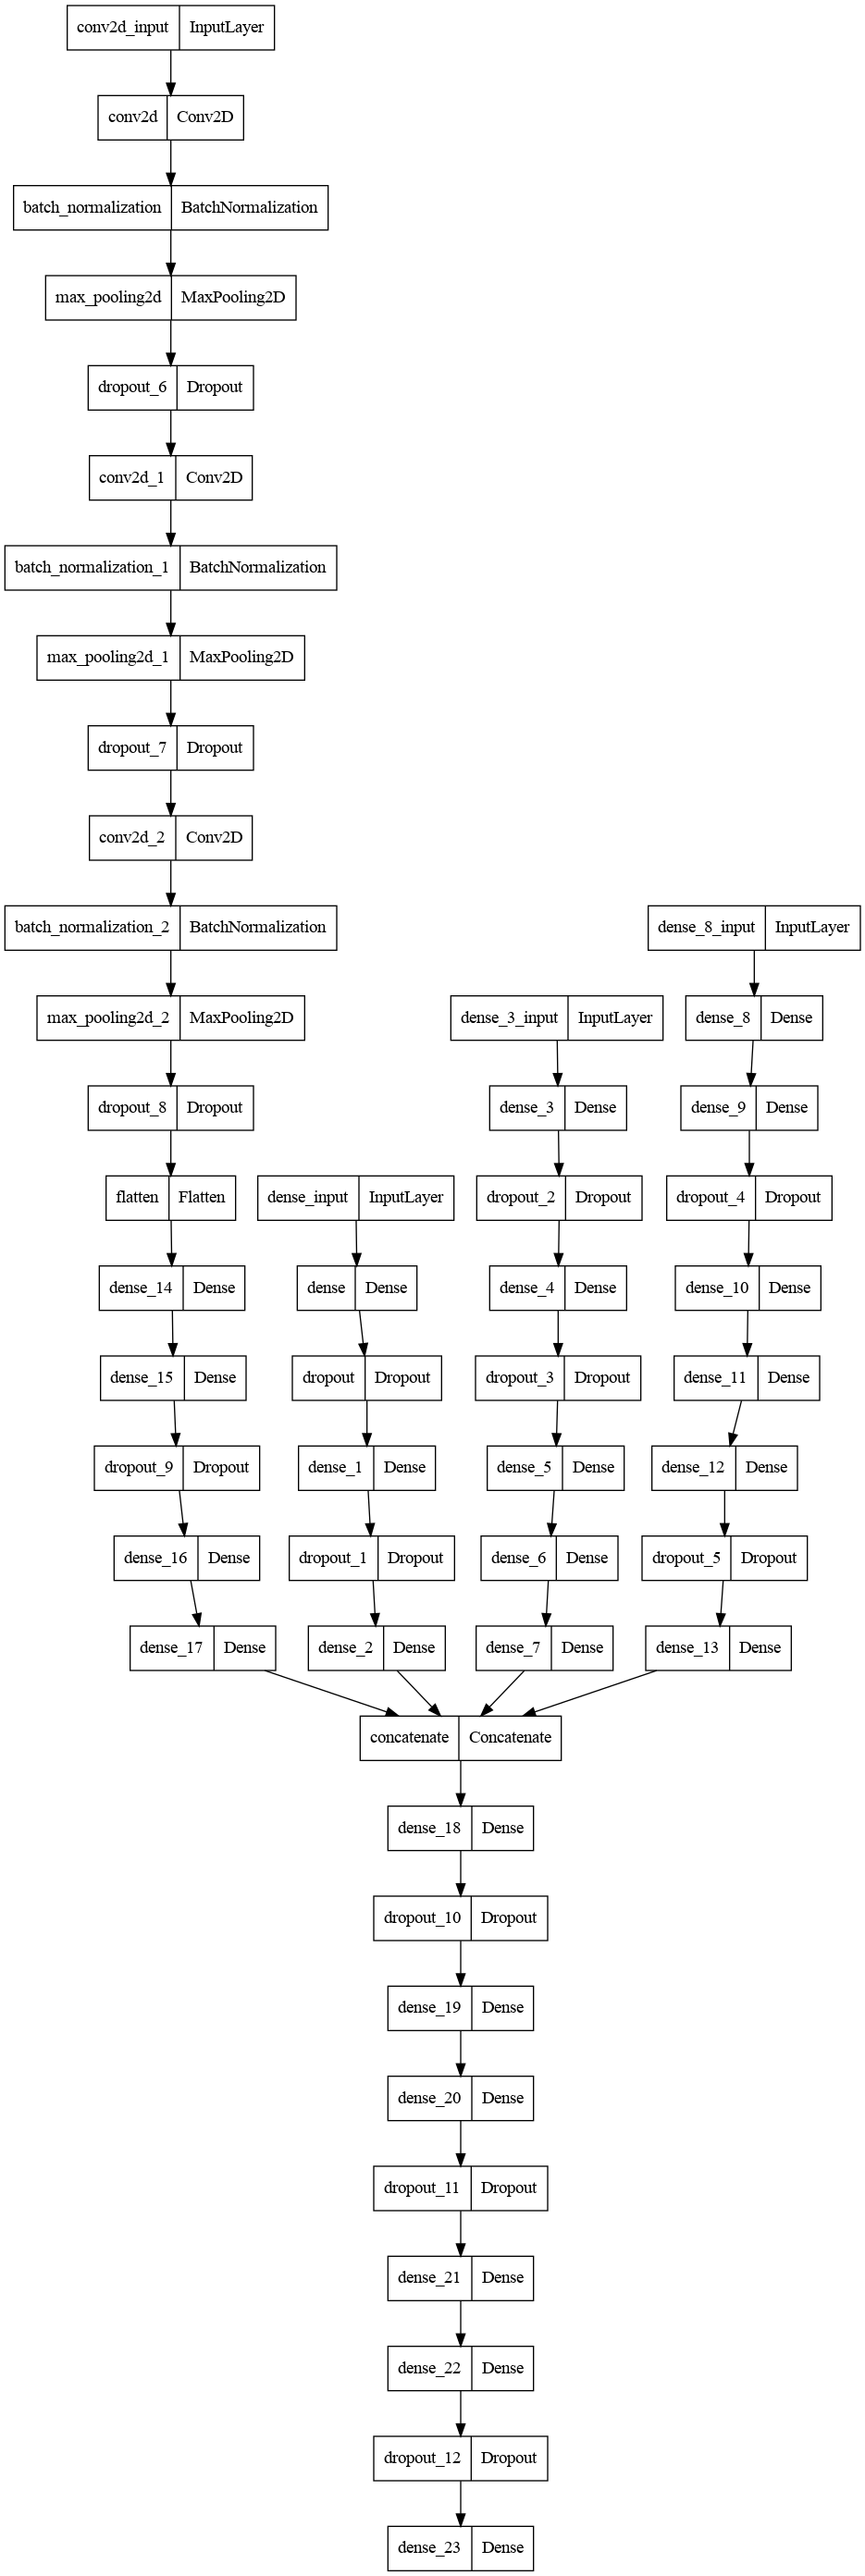

In [21]:
plot_model(model_4)

### Evaluando los modelos

In [99]:
score_1 = model_1.evaluate([X_test, X_img_test], y_test, verbose=1)
print('Test mse:', score_1[1])
print('Test mse inverser transform:', scalerY.inverse_transform(np.array(score_1[1]).reshape(-1,1)))
print('Test root mse inverser transform:', math.sqrt(scalerY.inverse_transform(np.array(score_1[1]).reshape(-1,1))))

54/54 [==============================] - 29s 539ms/step - loss: 0.0054 - mse: 0.0054
Test mse: 0.005431470461189747
Test mse inverser transform: [[12.20999904]]
Test root mse inverser transform: 3.494280904930675


In [97]:
score_2 = model_2.evaluate([X_test, X_img_test], y_test, verbose=1)
print('Test mse:', score_2[1])
print('Test mse inverser transform:', scalerY.inverse_transform(np.array(score_2[1]).reshape(-1,1)))
print('Test root mse inverser transform:', math.sqrt(scalerY.inverse_transform(np.array(score_2[1]).reshape(-1,1))))

2022-02-14 15:37:52.137598: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1036836864 exceeds 10% of free system memory.


54/54 [==============================] - 35s 652ms/step - loss: 0.0052 - mse: 0.0052
Test mse: 0.005161294247955084
Test mse inverser transform: [[12.0503249]]
Test root mse inverser transform: 3.471357789185876


In [95]:
score_3 = model_3.evaluate([X_test, X_img_test], y_test, verbose=1)
print('Test mse:', score_3[1])
print('Test mse inverse transform:', scalerY.inverse_transform(np.array(score_3[1]).reshape(-1,1)))
print('Test root mse inverse transform:', math.sqrt(scalerY.inverse_transform(np.array(score_3[1]).reshape(-1,1))))

2022-02-14 15:32:59.084324: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1036836864 exceeds 10% of free system memory.


54/54 [==============================] - 289s 5s/step - loss: 0.0525 - mse: 0.0525
Test mse: 0.05247092619538307
Test mse inverse transform: [[40.01031738]]
Test root mse inverse transform: 6.325370928370241


In [4]:
X_test_part_1 = X_test[:,:26]
X_test_part_2 = X_test[:,26:35]
X_test_part_3 = X_test[:,35:]

In [94]:
score_4 = model_4.evaluate([X_test_part_1, X_test_part_2, X_test_part_3, X_img_test], y_test, verbose=1)
print('Test mse:', score_4[1])
print('Test mse inverse transform:', scalerY.inverse_transform(np.array(score_4[1]).reshape(-1,1)))
print('Test root mse inverse transform:', math.sqrt(scalerY.inverse_transform(np.array(score_4[1]).reshape(-1,1))))

2022-02-14 15:32:23.370933: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1036836864 exceeds 10% of free system memory.


54/54 [==============================] - 34s 630ms/step - loss: 0.0039 - mse: 0.0039
Test mse: 0.0038799962494522333
Test mse inverse transform: [[11.29307778]]
Test root mse inverse transform: 3.3605174874453887


Al pasarlos por test el que mejor performance tiene es el modelo_4 (Entrenamiento por separado con tres ramas mlp y una cnn), aunque la diferencia se muy reducida en comparación con el modelo_1 y el modelo_2.
Esto puede ocurrir por la reducción del desvanecimiento de gradiente al entrenar en dos ocasiones (primer entrenamiento por ramas y posterior entrenamiento general) y/o por el mayor numero de parametros.
También se puede hipotetizar que la reducción de la dimensionalidad en el primer entrenamiento por ramas evita que las características con mayor peso oculten factores con menor impacto (aunque se han incluido capas de dropout para evitar esto).
Por último, el modelo_3, tiene mayor diferencia en su performance, para mejorar podríamos entrenar más capas del modelo VGG16, por limitaciones de la maquina (sin aceleración de GPU) se ha descartado hacer este experimento.

En general, los tres primero modelos podrían ser útiles para predecir el precio con un error medio +- 3,5€, tendría su utilidad para recomendar el precio a los hospedadores de la plataforma de Airbnb según las características marcadas.
Si se necesitará mayor exactitud para el aplicativo se podría probar tres vías de mejora:
1. Modificar hiperparámetros como los optimizadores, epochs u otros.
2. Modificar la arquitectura,reduciendo capas mantiendo el performance, modificando activiciones o incluyendo otro tipo de capas (AveragePool por Maxpool).
3. Revisar de nuevo el procesamiento del dato, incluyendo nuevas variables desechadas previamente y/o desechando variables seleccionadas (También podría mejorar la performance relizar el entrenamieto con un subconjunto de datos mayor).

En conclusión, aunque existen posibilidad de mejora de los modelos como se muestra arriba, el error obtenido es aceptable y los modelos pueden resultar útiles para ciertos aplicativos.
En este caso, no realizaremos más pruebas para mejorar la performance por limite de tiempo y recursos técnicos.